In [2]:
import json
import logging
import os
import re
from pathlib import Path

import anndata
import numpy as np
import pandas as pd
import scanpy as sc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import SVC, LinearSVC

In [3]:
import pollock.utils as utils
from pollock.dataloaders import normalize, get_train_dataloaders

In [4]:
import time
import torch

In [5]:
data_dir = '/data/pollock/benchmarking/pollock_datasets/'
fps = utils.listfiles(data_dir, regex=r'.h5ad')
fps = [fp for fp in fps if '_train' in fp or '_val' in fp]

fmap = {}
for fp in fps:
    dtype = fp.split('/')[-2]
    disease = fp.split('/')[-1].split('_')[0]
    partition = 'train' if '_train' in fp else 'val'
    
    if dtype not in fmap:
        fmap[dtype] = {}
    if disease not in fmap[dtype]:
        fmap[dtype][disease] = {}
    
    if not (dtype == 'snATACseq' and ('peaks' in fp or 'motif' in fp)):
        fmap[dtype][disease][partition] = fp
fmap

{'snRNAseq': {'ccrcc': {'train': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/ccrcc_train.h5ad',
   'val': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/ccrcc_val.h5ad'},
  'brca': {'train': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/brca_train.h5ad',
   'val': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/brca_val.h5ad'},
  'gbm': {'val': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/gbm_val.h5ad',
   'train': '/data/pollock/benchmarking/pollock_datasets/snRNAseq/gbm_train.h5ad'}},
 'snATACseq': {'brca': {'train': '/data/pollock/benchmarking/pollock_datasets/snATACseq/brca_gene_activity_train.h5ad',
   'val': '/data/pollock/benchmarking/pollock_datasets/snATACseq/brca_gene_activity_val.h5ad'},
  'ccrcc': {'train': '/data/pollock/benchmarking/pollock_datasets/snATACseq/ccrcc_gene_activity_train.h5ad',
   'val': '/data/pollock/benchmarking/pollock_datasets/snATACseq/ccrcc_gene_activity_val.h5ad'},
  'gbm': {'val': '/data/pollock/benchmarking/p

In [6]:
data_dir = '/data/pollock/benchmarking/pollock_datasets_with_folds/'
fps = utils.listfiles(data_dir, regex=r'.h5ad')
fps = [fp for fp in fps if '_train' in fp or '_val' in fp]

folds_fmap = {}
for fp in fps:
    dtype = fp.split('/')[-2]
    disease = fp.split('/')[-1].split('_')[0]
    partition = 'train' if '_train' in fp else 'val'
    fold = fp.split('/')[-1].split('_')[-2]
    
    if dtype not in folds_fmap:
        folds_fmap[dtype] = {}
    if disease not in folds_fmap[dtype]:
        folds_fmap[dtype][disease] = {}
    if fold not in folds_fmap[dtype][disease]:
        folds_fmap[dtype][disease][fold] = {}
    
    if not (dtype == 'snATACseq' and ('peaks' in fp or 'motif' in fp)):
        folds_fmap[dtype][disease][fold][partition] = fp
folds_fmap

{'snRNAseq': {'ccrcc': {'fold3': {'train': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold3_train.h5ad',
    'val': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold3_val.h5ad'},
   'fold1': {'val': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold1_val.h5ad',
    'train': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold1_train.h5ad'},
   'fold2': {'train': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold2_train.h5ad',
    'val': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold2_val.h5ad'},
   'fold0': {'val': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold0_val.h5ad',
    'train': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold0_train.h5ad'},
   'fold4': {'val': '/data/pollock/benchmarking/pollock_datasets_with_folds/snRNAseq/ccrcc_fold4_val.h5ad',
    'train': '/data/pol

In [7]:
def get_metrics(y_true_labels, y_pred_labels, overlapping_only=False):
    classes = sorted(set(y_true_labels))
    
    if overlapping_only:
        classes = [c for c in classes if c in y_pred_labels]
        y_pred_labels, y_true_labels = zip(*[(p, t) for p, t in zip(y_pred_labels, y_true_labels)
                              if t in classes])
        classes = sorted(set(y_true_labels).union(set(y_pred_labels)))

    y_pred = [classes.index(c) for c in y_pred_labels]
    y_true = [classes.index(c) for c in y_true_labels]

    d = classification_report(y_true, y_pred, labels=list(range(len(classes))), target_names=classes,
                             output_dict=True)
    d = pd.DataFrame.from_dict(d)
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(classes))))
    cm = pd.DataFrame(data=cm, index=classes, columns=classes)
    
    d.index.name = 'metric'
    cm.index.name = 'cell_type'
    
    return d, cm

#### predict cell types

###### scanpy

In [11]:
result_dir = '/data/pollock/benchmarking/results/scanpy/'

In [12]:
def normalize_for_scanpy(a, highly_variable=True):
    sc.pp.normalize_total(a, target_sum=1e4)
    sc.pp.log1p(a)
    
    if highly_variable:
        sc.pp.highly_variable_genes(a)
        a.raw = a
        a = a[:, a.var.highly_variable]
    
    sc.pp.scale(a)
    
    return a



def predict_scanpy(train, val):
    val.obs['orig_cell_type'] = val.obs['cell_type'].to_list()
    
    train, val = normalize_for_scanpy(train), normalize_for_scanpy(val, highly_variable=False)
    
    var_names = train.var_names.intersection(val.var_names)
    train = train[:, var_names]
    val = val[:, var_names]
    
    sc.pp.pca(train)
    sc.pp.neighbors(train)
    sc.tl.umap(train)
    
    sc.tl.ingest(val, train, obs='cell_type')
    
    val.obs['predicted_cell_type'] = val.obs['cell_type'].to_list()
    val.obs['cell_type'] = val.obs['orig_cell_type'].to_list()
    
    return val
    

In [10]:
to_prediction = {}
for dtype, d1 in fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        print(dtype, disease)
        train = sc.read_h5ad(d2['train'])
        val = sc.read_h5ad(d2['val'])
        
        to_prediction[dtype][disease] = predict_scanpy(train, val)
        

snRNAseq ccrcc


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
for dtype, d1 in to_prediction.items():
    for disease, a in d1.items():
        a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

In [13]:
for dtype, d1 in fmap.items():
    for disease, d2 in d1.items():
        print(dtype, disease)
        adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))
        y_pred = adata.obs['predicted_cell_type'].to_list()
        y_true = adata.obs['cell_type'].to_list()
        d, cm = get_metrics(y_true, y_pred)
        
        d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
        cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc
snRNAseq brca
snRNAseq gbm
snATACseq brca
snATACseq ccrcc
snATACseq gbm
scRNAseq cesc
scRNAseq myeloma
scRNAseq brca
scRNAseq hnscc
scRNAseq pdac
scRNAseq melanoma


In [13]:
# with folds
result_dir = '/data/pollock/benchmarking/results/scanpy/interdataset_with_folds'

In [14]:
to_prediction = {}
for dtype, d1 in folds_fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        to_prediction[dtype][disease] = {}
        for fold, d3 in d2.items():
            print(dtype, disease, fold)
            train = sc.read_h5ad(d3['train'])
            val = sc.read_h5ad(d3['val'])

            to_prediction[dtype][disease][fold] = predict_scanpy(train, val)
        

snRNAseq ccrcc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq ccrcc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq ccrcc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq ccrcc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq ccrcc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snRNAseq gbm fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq ccrcc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


snATACseq gbm fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq hnscc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq cesc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq myeloma fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq melanoma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


scRNAseq pdac fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [15]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'orig_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is dep

In [16]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            print(dtype, disease, fold)
            adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))
            y_pred = adata.obs['predicted_cell_type'].to_list()
            y_true = adata.obs['cell_type'].to_list()
            d, cm = get_metrics(y_true, y_pred)

            d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
            cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc fold3
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold0
snRNAseq ccrcc fold4
snRNAseq brca fold2
snRNAseq brca fold1
snRNAseq brca fold3
snRNAseq brca fold0
snRNAseq brca fold4
snRNAseq gbm fold4
snRNAseq gbm fold3
snRNAseq gbm fold0
snRNAseq gbm fold2
snRNAseq gbm fold1
snATACseq ccrcc fold3
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold0
snATACseq ccrcc fold4
snATACseq brca fold2
snATACseq brca fold1
snATACseq brca fold3
snATACseq brca fold0
snATACseq brca fold4
snATACseq gbm fold4
snATACseq gbm fold3
snATACseq gbm fold0
snATACseq gbm fold2
snATACseq gbm fold1
scRNAseq hnscc fold0
scRNAseq hnscc fold4
scRNAseq hnscc fold1
scRNAseq hnscc fold3
scRNAseq hnscc fold2
scRNAseq cesc fold4
scRNAseq cesc fold3
scRNAseq cesc fold2
scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq brca fold2
scRNAseq brca fold1
scRNAseq brca fold3
scRNAseq brca fold0
scRNAseq brca fold4
scRNAseq myeloma fold0
scRNAseq myeloma fold1
scRNAseq myeloma fold3
scRNAseq my

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold2
scRNAseq melanoma fold3
scRNAseq melanoma fold0
scRNAseq melanoma fold2
scRNAseq melanoma fold1
scRNAseq melanoma fold4
scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold1
scRNAseq pdac fold4
scRNAseq pdac fold0


###### svm

In [20]:
def predict_svm(train, val, method='linear'):    
    train, val = normalize(train), normalize(val)
    
    var_names = train.var_names.intersection(val.var_names)
    train = train[:, var_names]
    val = val[:, var_names]
    
    X = train.X.toarray() if 'sparse' in str(type(train.X)).lower() else train.X
    labels = train.obs['cell_type'].to_list()
    to_label = sorted(set(labels))
    y = [to_label.index(l) for l in labels]

    clf = LinearSVC() if method == 'linear' else SVC()
    clf = CalibratedClassifierCV(clf)
    
    clf.fit(X, y)
    
    X = val.X.toarray() if 'sparse' in str(type(val.X)).lower() else val.X
    preds = clf.predict(X)
    probs = clf.predict_proba(X)

    val.obs['predicted_cell_type'] = [to_label[c] for c in preds]
    
    prob_df = pd.DataFrame(data=probs, index=val.obs.index.to_list(),
                          columns=[f'probability {ct}' for ct in to_label])
    
    val.obs = pd.concat((val.obs, prob_df), axis=1)
    
    return val
    

In [10]:
result_dir = '/data/pollock/benchmarking/results/svm_linear/'

In [11]:
to_prediction = {}
for dtype, d1 in fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        print(dtype, disease)
        train = sc.read_h5ad(d2['train'])
        val = sc.read_h5ad(d2['val'])
        
        to_prediction[dtype][disease] = predict_svm(train, val, method='linear')

snRNAseq ccrcc


Trying to set attribute `.obs` of view, copying.


snRNAseq brca


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm


Trying to set attribute `.obs` of view, copying.


snATACseq brca


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc


Trying to set attribute `.obs` of view, copying.


snATACseq gbm


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma


Trying to set attribute `.obs` of view, copying.


scRNAseq brca


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma


Trying to set attribute `.obs` of view, copying.


In [14]:
for dtype, d1 in to_prediction.items():
    for disease, a in d1.items():
        a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))

In [15]:
for dtype, d1 in fmap.items():
    for disease, d2 in d1.items():
        print(dtype, disease)
        adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))
        y_pred = adata.obs['predicted_cell_type'].to_list()
        y_true = adata.obs['cell_type'].to_list()
        d, cm = get_metrics(y_true, y_pred)
        
        d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
        cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc
snRNAseq brca
snRNAseq gbm
snATACseq brca
snATACseq ccrcc
snATACseq gbm
scRNAseq cesc
scRNAseq myeloma
scRNAseq brca
scRNAseq hnscc
scRNAseq pdac
scRNAseq melanoma


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [22]:
# with folds
result_dir = '/data/pollock/benchmarking/results/svm_linear/interdataset_with_folds'

In [21]:
to_prediction = {}
for dtype, d1 in folds_fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        to_prediction[dtype][disease] = {}
        for fold, d3 in d2.items():
            print(dtype, disease, fold)
            train = sc.read_h5ad(d3['train'])
            val = sc.read_h5ad(d3['val'])

            to_prediction[dtype][disease][fold] = predict_svm(train, val, method='linear')
        

snRNAseq ccrcc fold3


Trying to set attribute `.obs` of view, copying.


snRNAseq ccrcc fold1


Trying to set attribute `.obs` of view, copying.


snRNAseq ccrcc fold2


Trying to set attribute `.obs` of view, copying.


snRNAseq ccrcc fold0


Trying to set attribute `.obs` of view, copying.


snRNAseq ccrcc fold4


Trying to set attribute `.obs` of view, copying.


snRNAseq brca fold2


Trying to set attribute `.obs` of view, copying.


snRNAseq brca fold1


Trying to set attribute `.obs` of view, copying.


snRNAseq brca fold3


Trying to set attribute `.obs` of view, copying.


snRNAseq brca fold0


Trying to set attribute `.obs` of view, copying.


snRNAseq brca fold4


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm fold4


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm fold3


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm fold0


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm fold2


Trying to set attribute `.obs` of view, copying.


snRNAseq gbm fold1


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc fold3


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc fold1


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc fold2


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc fold0


Trying to set attribute `.obs` of view, copying.


snATACseq ccrcc fold4


Trying to set attribute `.obs` of view, copying.


snATACseq brca fold2


Trying to set attribute `.obs` of view, copying.


snATACseq brca fold1


Trying to set attribute `.obs` of view, copying.


snATACseq brca fold3


Trying to set attribute `.obs` of view, copying.


snATACseq brca fold0


Trying to set attribute `.obs` of view, copying.


snATACseq brca fold4


Trying to set attribute `.obs` of view, copying.


snATACseq gbm fold4


Trying to set attribute `.obs` of view, copying.


snATACseq gbm fold3


Trying to set attribute `.obs` of view, copying.


snATACseq gbm fold0


Trying to set attribute `.obs` of view, copying.


snATACseq gbm fold2


Trying to set attribute `.obs` of view, copying.


snATACseq gbm fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc fold0


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq hnscc fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc fold0


Trying to set attribute `.obs` of view, copying.


scRNAseq cesc fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq brca fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq brca fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq brca fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq brca fold0


Trying to set attribute `.obs` of view, copying.


scRNAseq brca fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma fold0


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq myeloma fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma fold0


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq melanoma fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac fold2


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac fold3


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac fold1


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac fold4


Trying to set attribute `.obs` of view, copying.


scRNAseq pdac fold0


Trying to set attribute `.obs` of view, copying.


In [23]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

In [24]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            print(dtype, disease, fold)
            adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))
            y_pred = adata.obs['predicted_cell_type'].to_list()
            y_true = adata.obs['cell_type'].to_list()
            d, cm = get_metrics(y_true, y_pred)

            d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
            cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc fold3
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold0
snRNAseq ccrcc fold4
snRNAseq brca fold2
snRNAseq brca fold1
snRNAseq brca fold3
snRNAseq brca fold0
snRNAseq brca fold4
snRNAseq gbm fold4
snRNAseq gbm fold3
snRNAseq gbm fold0
snRNAseq gbm fold2
snRNAseq gbm fold1
snATACseq ccrcc fold3
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold0
snATACseq ccrcc fold4
snATACseq brca fold2
snATACseq brca fold1
snATACseq brca fold3
snATACseq brca fold0
snATACseq brca fold4
snATACseq gbm fold4
snATACseq gbm fold3
snATACseq gbm fold0
snATACseq gbm fold2
snATACseq gbm fold1
scRNAseq hnscc fold0
scRNAseq hnscc fold4
scRNAseq hnscc fold1
scRNAseq hnscc fold3
scRNAseq hnscc fold2
scRNAseq cesc fold4
scRNAseq cesc fold3
scRNAseq cesc fold2
scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq brca fold2
scRNAseq brca fold1
scRNAseq brca fold3
scRNAseq brca fold0
scRNAseq brca fold4
scRNAseq myeloma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq melanoma fold3
scRNAseq melanoma fold0
scRNAseq melanoma fold2
scRNAseq melanoma fold1
scRNAseq melanoma fold4
scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold1
scRNAseq pdac fold4
scRNAseq pdac fold0


###### MLP

In [25]:
class MLP(torch.nn.Module):
    def __init__(self, genes, classes, method='small'):
        """
        MLP
        """
        super(MLP, self).__init__()
        self.genes = genes
        self.n_genes = len(genes)
        self.classes = classes
        self.n_classes = len(classes)

        if method == 'small':
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(self.n_genes, 128),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(128, 32),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(32, 16),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(16, 8),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(8, self.n_classes),
                torch.nn.Softmax(dim=1)
            )
        else:
            self.layers = torch.nn.Sequential(
                torch.nn.Linear(self.n_genes, 64),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(64, 16),
                torch.nn.ReLU(),
                torch.nn.Dropout(.1),
                torch.nn.Linear(16, self.n_classes),
                torch.nn.Softmax(dim=1)
            )
            
    def forward(self, x):
        x = self.layers(x)
        return x

In [26]:
def train_mlp(train_dl, val_dl, lr=1e-4, epochs=25):
    model = MLP(train_dl.dataset.adata.var.index.to_list(), train_dl.dataset.cell_types,
                method='small' if train_dl.dataset.adata.shape[0] < 5000 else 'large')
    model = model.cuda()

    criteria = torch.nn.CrossEntropyLoss()

    opt = torch.optim.Adam(model.parameters(), lr=lr)
    
    
    for epoch in range(epochs):
        train_loss, val_loss = 0., 0.
        start = time.time()
        model.train()
        for i, b in enumerate(train_dl):
            x, y = b['x'], b['y']
            x, y = x.cuda(), y.cuda()
            opt.zero_grad()
            out = model(x)
            loss = criteria(out, y)
            loss.backward()
            opt.step()

            train_loss += float(loss.detach().cpu())
        train_loss = train_loss / len(train_dl)

        time_delta = time.time() - start
        model.eval()
        with torch.no_grad():
            for i, b in enumerate(val_dl):
                x, y = b['x'], b['y']
                x, y = x.cuda(), y.cuda()

                out = model(x)
                loss = criteria(out, y)
                val_loss += float(loss.detach().cpu())


        val_loss = val_loss / len(val_dl)

        print(f'epoch: {epoch}, train loss: {train_loss:.3f}, val loss: {val_loss:.3f}, time: {time_delta:.2f}')
    
    return model

def mlp_predict_dl(dl, model):
    y_prob = None
    model.eval()
    with torch.no_grad():
        for i, b in enumerate(dl):
            x, y = b['x'], b['y']
            x, y = x.cuda(), y.cuda()

            out = model(x).detach().cpu().numpy()

            if y_prob is None:
                y_prob = out
            else:
                y_prob = np.concatenate((y_prob, out), axis=0)
                
    labels = [model.classes[i] for i in np.argmax(y_prob, axis=1)]
    
    return labels, y_prob

def mlp_predict(train, val, epochs=25):
    train_dl, val_dl = get_train_dataloaders(train, val)
    model = train_mlp(train_dl, val_dl, epochs=epochs)
    labels, probs = mlp_predict_dl(val_dl, model)
    val.obs['predicted_cell_type'] = labels

    prob_df = pd.DataFrame(data=probs, index=val.obs.index.to_list(),
                          columns=[f'probability {ct}' for ct in model.classes])

    val.obs = pd.concat((val.obs, prob_df), axis=1)
    
    return val

In [32]:
result_dir = '/data/pollock/benchmarking/results/mlp/'

In [33]:
to_prediction = {}
for dtype, d1 in fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        print(dtype, disease)
        train = sc.read_h5ad(d2['train'])
        val = sc.read_h5ad(d2['val'])
        
        to_prediction[dtype][disease] = mlp_predict(train, val,
            epochs=10 if dtype=='scRNAseq' else 25)
        

snRNAseq ccrcc


2022-01-19 07:28:55,625 24684 genes overlap with model after filtering
2022-01-19 07:28:55,627 1318 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.384, val loss: 2.351, time: 1.74
epoch: 1, train loss: 2.283, val loss: 2.203, time: 1.36
epoch: 2, train loss: 2.190, val loss: 2.136, time: 1.33
epoch: 3, train loss: 2.135, val loss: 2.078, time: 1.41
epoch: 4, train loss: 2.082, val loss: 2.014, time: 1.31
epoch: 5, train loss: 2.032, val loss: 1.959, time: 1.31
epoch: 6, train loss: 1.985, val loss: 1.910, time: 1.31
epoch: 7, train loss: 1.948, val loss: 1.879, time: 1.31
epoch: 8, train loss: 1.918, val loss: 1.850, time: 1.31
epoch: 9, train loss: 1.886, val loss: 1.825, time: 1.29
epoch: 10, train loss: 1.865, val loss: 1.803, time: 1.37
epoch: 11, train loss: 1.835, val loss: 1.785, time: 1.34
epoch: 12, train loss: 1.815, val loss: 1.770, time: 1.31
epoch: 13, train loss: 1.802, val loss: 1.757, time: 1.30
epoch: 14, train loss: 1.789, val loss: 1.750, time: 1.30
epoch: 15, train loss: 1.775, val loss: 1.741, time: 1.30
epoch: 16, train loss: 1.760, val loss: 1.731, time: 1.30
epoch: 17, train loss: 1

2022-01-19 07:30:00,411 25360 genes overlap with model after filtering
2022-01-19 07:30:00,412 1183 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.475, val loss: 2.330, time: 1.30
epoch: 1, train loss: 2.233, val loss: 2.145, time: 1.28
epoch: 2, train loss: 2.098, val loss: 2.045, time: 1.26
epoch: 3, train loss: 1.993, val loss: 1.985, time: 1.28
epoch: 4, train loss: 1.928, val loss: 1.945, time: 1.27
epoch: 5, train loss: 1.871, val loss: 1.894, time: 1.32
epoch: 6, train loss: 1.831, val loss: 1.873, time: 1.36
epoch: 7, train loss: 1.812, val loss: 1.861, time: 1.25
epoch: 8, train loss: 1.793, val loss: 1.853, time: 1.25
epoch: 9, train loss: 1.783, val loss: 1.842, time: 1.26
epoch: 10, train loss: 1.764, val loss: 1.834, time: 1.24
epoch: 11, train loss: 1.749, val loss: 1.826, time: 1.24
epoch: 12, train loss: 1.743, val loss: 1.823, time: 1.24
epoch: 13, train loss: 1.738, val loss: 1.819, time: 1.26
epoch: 14, train loss: 1.733, val loss: 1.818, time: 1.23
epoch: 15, train loss: 1.728, val loss: 1.815, time: 1.29
epoch: 16, train loss: 1.727, val loss: 1.814, time: 1.31
epoch: 17, train loss: 1

2022-01-19 07:31:01,326 25009 genes overlap with model after filtering
2022-01-19 07:31:01,327 1142 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.189, val loss: 2.159, time: 1.01
epoch: 1, train loss: 2.090, val loss: 1.989, time: 1.02
epoch: 2, train loss: 1.978, val loss: 1.900, time: 1.08
epoch: 3, train loss: 1.909, val loss: 1.840, time: 1.08
epoch: 4, train loss: 1.848, val loss: 1.769, time: 1.09
epoch: 5, train loss: 1.799, val loss: 1.716, time: 1.09
epoch: 6, train loss: 1.745, val loss: 1.649, time: 1.09
epoch: 7, train loss: 1.701, val loss: 1.617, time: 1.09
epoch: 8, train loss: 1.653, val loss: 1.559, time: 1.10
epoch: 9, train loss: 1.616, val loss: 1.535, time: 1.10
epoch: 10, train loss: 1.595, val loss: 1.527, time: 1.10
epoch: 11, train loss: 1.586, val loss: 1.523, time: 1.11
epoch: 12, train loss: 1.584, val loss: 1.519, time: 1.09
epoch: 13, train loss: 1.573, val loss: 1.513, time: 1.03
epoch: 14, train loss: 1.564, val loss: 1.507, time: 1.09
epoch: 15, train loss: 1.564, val loss: 1.499, time: 1.09
epoch: 16, train loss: 1.546, val loss: 1.485, time: 1.10
epoch: 17, train loss: 1

2022-01-19 07:31:52,531 19699 genes overlap with model after filtering
2022-01-19 07:31:52,532 17 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.059, val loss: 2.021, time: 0.94
epoch: 1, train loss: 1.979, val loss: 1.928, time: 1.02
epoch: 2, train loss: 1.904, val loss: 1.857, time: 1.01
epoch: 3, train loss: 1.838, val loss: 1.767, time: 1.02
epoch: 4, train loss: 1.772, val loss: 1.735, time: 1.02
epoch: 5, train loss: 1.747, val loss: 1.720, time: 1.02
epoch: 6, train loss: 1.726, val loss: 1.702, time: 1.02
epoch: 7, train loss: 1.702, val loss: 1.676, time: 1.03
epoch: 8, train loss: 1.670, val loss: 1.648, time: 1.00
epoch: 9, train loss: 1.644, val loss: 1.627, time: 1.03
epoch: 10, train loss: 1.621, val loss: 1.605, time: 1.02
epoch: 11, train loss: 1.582, val loss: 1.569, time: 1.02
epoch: 12, train loss: 1.553, val loss: 1.539, time: 1.03
epoch: 13, train loss: 1.527, val loss: 1.519, time: 1.03
epoch: 14, train loss: 1.510, val loss: 1.507, time: 1.03
epoch: 15, train loss: 1.495, val loss: 1.493, time: 1.03
epoch: 16, train loss: 1.482, val loss: 1.478, time: 1.03
epoch: 17, train loss: 1

2022-01-19 07:32:42,152 19677 genes overlap with model after filtering
2022-01-19 07:32:42,153 40 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 1.785, val loss: 1.776, time: 0.78
epoch: 1, train loss: 1.755, val loss: 1.722, time: 0.86
epoch: 2, train loss: 1.648, val loss: 1.566, time: 0.85
epoch: 3, train loss: 1.513, val loss: 1.460, time: 0.85
epoch: 4, train loss: 1.439, val loss: 1.403, time: 0.79
epoch: 5, train loss: 1.396, val loss: 1.378, time: 0.86
epoch: 6, train loss: 1.376, val loss: 1.366, time: 0.85
epoch: 7, train loss: 1.363, val loss: 1.359, time: 0.85
epoch: 8, train loss: 1.355, val loss: 1.353, time: 0.85
epoch: 9, train loss: 1.345, val loss: 1.349, time: 0.91
epoch: 10, train loss: 1.336, val loss: 1.345, time: 0.86
epoch: 11, train loss: 1.334, val loss: 1.341, time: 0.86
epoch: 12, train loss: 1.321, val loss: 1.334, time: 0.85
epoch: 13, train loss: 1.311, val loss: 1.319, time: 0.85
epoch: 14, train loss: 1.291, val loss: 1.284, time: 0.85
epoch: 15, train loss: 1.263, val loss: 1.251, time: 0.85
epoch: 16, train loss: 1.236, val loss: 1.240, time: 0.85
epoch: 17, train loss: 1

2022-01-19 07:33:23,713 19698 genes overlap with model after filtering
2022-01-19 07:33:23,714 30 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.065, val loss: 2.048, time: 0.88
epoch: 1, train loss: 2.019, val loss: 1.963, time: 0.96
epoch: 2, train loss: 1.928, val loss: 1.852, time: 0.96
epoch: 3, train loss: 1.858, val loss: 1.794, time: 0.96
epoch: 4, train loss: 1.777, val loss: 1.723, time: 0.97
epoch: 5, train loss: 1.701, val loss: 1.663, time: 0.97
epoch: 6, train loss: 1.660, val loss: 1.635, time: 0.97
epoch: 7, train loss: 1.635, val loss: 1.621, time: 0.97
epoch: 8, train loss: 1.619, val loss: 1.612, time: 0.97
epoch: 9, train loss: 1.612, val loss: 1.604, time: 0.90
epoch: 10, train loss: 1.602, val loss: 1.595, time: 0.95
epoch: 11, train loss: 1.593, val loss: 1.583, time: 1.00
epoch: 12, train loss: 1.583, val loss: 1.565, time: 0.99
epoch: 13, train loss: 1.568, val loss: 1.537, time: 0.96
epoch: 14, train loss: 1.549, val loss: 1.506, time: 0.96
epoch: 15, train loss: 1.531, val loss: 1.493, time: 0.95
epoch: 16, train loss: 1.514, val loss: 1.482, time: 0.96
epoch: 17, train loss: 1

2022-01-19 07:34:07,252 21146 genes overlap with model after filtering
2022-01-19 07:34:07,253 703 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.385, val loss: 2.350, time: 1.23
epoch: 1, train loss: 2.282, val loss: 2.158, time: 1.24
epoch: 2, train loss: 2.134, val loss: 1.992, time: 1.24
epoch: 3, train loss: 2.035, val loss: 1.900, time: 1.24
epoch: 4, train loss: 1.989, val loss: 1.863, time: 1.22
epoch: 5, train loss: 1.953, val loss: 1.841, time: 1.23
epoch: 6, train loss: 1.924, val loss: 1.820, time: 1.22
epoch: 7, train loss: 1.898, val loss: 1.801, time: 1.24
epoch: 8, train loss: 1.873, val loss: 1.780, time: 1.24
epoch: 9, train loss: 1.853, val loss: 1.767, time: 1.26
scRNAseq myeloma


2022-01-19 07:34:31,628 18733 genes overlap with model after filtering
2022-01-19 07:34:31,629 1290 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.388, val loss: 2.370, time: 0.96
epoch: 1, train loss: 2.339, val loss: 2.286, time: 1.00
epoch: 2, train loss: 2.266, val loss: 2.226, time: 1.01
epoch: 3, train loss: 2.205, val loss: 2.184, time: 1.00
epoch: 4, train loss: 2.158, val loss: 2.121, time: 1.00
epoch: 5, train loss: 2.072, val loss: 1.999, time: 1.00
epoch: 6, train loss: 1.988, val loss: 1.911, time: 1.01
epoch: 7, train loss: 1.903, val loss: 1.793, time: 1.00
epoch: 8, train loss: 1.824, val loss: 1.723, time: 1.00
epoch: 9, train loss: 1.780, val loss: 1.685, time: 1.00
scRNAseq brca


2022-01-19 07:34:51,449 22285 genes overlap with model after filtering
2022-01-19 07:34:51,450 1268 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.441, val loss: 2.269, time: 1.56
epoch: 1, train loss: 2.163, val loss: 2.093, time: 1.52
epoch: 2, train loss: 2.016, val loss: 1.980, time: 1.51
epoch: 3, train loss: 1.920, val loss: 1.927, time: 1.54
epoch: 4, train loss: 1.861, val loss: 1.897, time: 1.56
epoch: 5, train loss: 1.813, val loss: 1.880, time: 1.54
epoch: 6, train loss: 1.796, val loss: 1.869, time: 1.56
epoch: 7, train loss: 1.775, val loss: 1.862, time: 1.48
epoch: 8, train loss: 1.767, val loss: 1.858, time: 1.65
epoch: 9, train loss: 1.755, val loss: 1.852, time: 1.54
scRNAseq hnscc


2022-01-19 07:35:22,191 21915 genes overlap with model after filtering
2022-01-19 07:35:22,193 1008 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.281, val loss: 2.093, time: 1.32
epoch: 1, train loss: 1.952, val loss: 1.837, time: 1.29
epoch: 2, train loss: 1.777, val loss: 1.758, time: 1.32
epoch: 3, train loss: 1.704, val loss: 1.727, time: 1.34
epoch: 4, train loss: 1.667, val loss: 1.711, time: 1.33
epoch: 5, train loss: 1.642, val loss: 1.702, time: 1.37
epoch: 6, train loss: 1.626, val loss: 1.696, time: 1.42
epoch: 7, train loss: 1.613, val loss: 1.693, time: 1.43
epoch: 8, train loss: 1.605, val loss: 1.689, time: 1.37
epoch: 9, train loss: 1.594, val loss: 1.687, time: 1.33
scRNAseq pdac


2022-01-19 07:35:51,104 23831 genes overlap with model after filtering
2022-01-19 07:35:51,105 1188 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.647, val loss: 2.451, time: 1.98
epoch: 1, train loss: 2.368, val loss: 2.269, time: 2.15
epoch: 2, train loss: 2.237, val loss: 2.200, time: 1.97
epoch: 3, train loss: 2.179, val loss: 2.171, time: 2.03
epoch: 4, train loss: 2.135, val loss: 2.154, time: 2.10
epoch: 5, train loss: 2.114, val loss: 2.145, time: 1.98
epoch: 6, train loss: 2.101, val loss: 2.141, time: 1.97
epoch: 7, train loss: 2.090, val loss: 2.137, time: 1.98
epoch: 8, train loss: 2.083, val loss: 2.135, time: 1.98
epoch: 9, train loss: 2.081, val loss: 2.133, time: 1.97
scRNAseq melanoma


2022-01-19 07:36:30,740 19219 genes overlap with model after filtering
2022-01-19 07:36:30,741 1385 genes missing from dataset after filtering
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, train loss: 2.293, val loss: 2.272, time: 1.07
epoch: 1, train loss: 2.227, val loss: 2.173, time: 1.16
epoch: 2, train loss: 2.134, val loss: 2.083, time: 1.16
epoch: 3, train loss: 2.069, val loss: 2.034, time: 1.01
epoch: 4, train loss: 2.027, val loss: 1.996, time: 1.03
epoch: 5, train loss: 1.988, val loss: 1.938, time: 1.03
epoch: 6, train loss: 1.918, val loss: 1.806, time: 1.03
epoch: 7, train loss: 1.824, val loss: 1.711, time: 1.03
epoch: 8, train loss: 1.786, val loss: 1.681, time: 1.02
epoch: 9, train loss: 1.748, val loss: 1.658, time: 1.02


In [34]:
for dtype, d1 in to_prediction.items():
    for disease, a in d1.items():
        a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

In [35]:
for dtype, d1 in fmap.items():
    for disease, d2 in d1.items():
        print(dtype, disease)
        adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}.h5ad'))
        y_pred = adata.obs['predicted_cell_type'].to_list()
        y_true = adata.obs['cell_type'].to_list()
        d, cm = get_metrics(y_true, y_pred)
        
        d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
        cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc
snRNAseq brca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

snRNAseq gbm
snATACseq brca


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

snATACseq ccrcc
snATACseq gbm
scRNAseq cesc


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma
scRNAseq brca
scRNAseq hnscc
scRNAseq pdac
scRNAseq melanoma


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

In [28]:
# with folds
result_dir = '/data/pollock/benchmarking/results/mlp/interdataset_with_folds'

In [29]:
to_prediction = {}
for dtype, d1 in folds_fmap.items():
    to_prediction[dtype] = {}
    for disease, d2 in d1.items():
        to_prediction[dtype][disease] = {}
        for fold, d3 in d2.items():
            print(dtype, disease, fold)
            train = sc.read_h5ad(d3['train'])
            val = sc.read_h5ad(d3['val'])

            to_prediction[dtype][disease][fold] = mlp_predict(
                train, val, epochs=10 if dtype=='scRNAseq' else 25)
        

snRNAseq ccrcc fold3


2022-03-25 10:10:45,824 24602 genes overlap with model after filtering
2022-03-25 10:10:45,825 1513 genes missing from dataset after filtering


epoch: 0, train loss: 2.269, val loss: 2.086, time: 1.71
epoch: 1, train loss: 1.974, val loss: 1.915, time: 1.22
epoch: 2, train loss: 1.838, val loss: 1.814, time: 1.31
epoch: 3, train loss: 1.741, val loss: 1.763, time: 1.25
epoch: 4, train loss: 1.689, val loss: 1.721, time: 1.35
epoch: 5, train loss: 1.642, val loss: 1.678, time: 1.24
epoch: 6, train loss: 1.609, val loss: 1.656, time: 1.21
epoch: 7, train loss: 1.594, val loss: 1.649, time: 1.24
epoch: 8, train loss: 1.580, val loss: 1.640, time: 1.27
epoch: 9, train loss: 1.572, val loss: 1.636, time: 1.23
epoch: 10, train loss: 1.568, val loss: 1.633, time: 1.23
epoch: 11, train loss: 1.564, val loss: 1.632, time: 1.23
epoch: 12, train loss: 1.561, val loss: 1.629, time: 1.25
epoch: 13, train loss: 1.560, val loss: 1.629, time: 1.34
epoch: 14, train loss: 1.556, val loss: 1.629, time: 1.21
epoch: 15, train loss: 1.555, val loss: 1.627, time: 1.21
epoch: 16, train loss: 1.555, val loss: 1.626, time: 1.34
epoch: 17, train loss: 1

2022-03-25 10:11:49,239 24613 genes overlap with model after filtering
2022-03-25 10:11:49,241 1496 genes missing from dataset after filtering


epoch: 0, train loss: 2.268, val loss: 2.080, time: 1.20
epoch: 1, train loss: 1.936, val loss: 1.875, time: 1.24
epoch: 2, train loss: 1.787, val loss: 1.768, time: 1.25
epoch: 3, train loss: 1.697, val loss: 1.703, time: 1.21
epoch: 4, train loss: 1.657, val loss: 1.679, time: 1.30
epoch: 5, train loss: 1.628, val loss: 1.662, time: 1.20
epoch: 6, train loss: 1.602, val loss: 1.651, time: 1.23
epoch: 7, train loss: 1.591, val loss: 1.645, time: 1.24
epoch: 8, train loss: 1.579, val loss: 1.640, time: 1.25
epoch: 9, train loss: 1.575, val loss: 1.636, time: 1.35
epoch: 10, train loss: 1.572, val loss: 1.633, time: 1.22
epoch: 11, train loss: 1.565, val loss: 1.630, time: 1.24
epoch: 12, train loss: 1.564, val loss: 1.628, time: 1.25
epoch: 13, train loss: 1.562, val loss: 1.626, time: 1.22
epoch: 14, train loss: 1.561, val loss: 1.625, time: 1.24
epoch: 15, train loss: 1.558, val loss: 1.625, time: 1.27
epoch: 16, train loss: 1.558, val loss: 1.624, time: 1.21
epoch: 17, train loss: 1

2022-03-25 10:12:47,672 24633 genes overlap with model after filtering
2022-03-25 10:12:47,673 1406 genes missing from dataset after filtering


epoch: 0, train loss: 2.252, val loss: 2.010, time: 1.19
epoch: 1, train loss: 1.944, val loss: 1.843, time: 1.29
epoch: 2, train loss: 1.802, val loss: 1.749, time: 1.31
epoch: 3, train loss: 1.694, val loss: 1.689, time: 1.25
epoch: 4, train loss: 1.634, val loss: 1.664, time: 1.22
epoch: 5, train loss: 1.612, val loss: 1.653, time: 1.23
epoch: 6, train loss: 1.594, val loss: 1.644, time: 1.22
epoch: 7, train loss: 1.585, val loss: 1.638, time: 1.30
epoch: 8, train loss: 1.575, val loss: 1.633, time: 1.28
epoch: 9, train loss: 1.571, val loss: 1.632, time: 1.26
epoch: 10, train loss: 1.566, val loss: 1.630, time: 1.27
epoch: 11, train loss: 1.565, val loss: 1.627, time: 1.27
epoch: 12, train loss: 1.560, val loss: 1.626, time: 1.39
epoch: 13, train loss: 1.559, val loss: 1.623, time: 1.28
epoch: 14, train loss: 1.560, val loss: 1.623, time: 1.30
epoch: 15, train loss: 1.556, val loss: 1.623, time: 1.28
epoch: 16, train loss: 1.556, val loss: 1.622, time: 1.30
epoch: 17, train loss: 1

2022-03-25 10:13:46,971 24598 genes overlap with model after filtering
2022-03-25 10:13:46,972 1535 genes missing from dataset after filtering


epoch: 0, train loss: 2.278, val loss: 2.076, time: 1.19
epoch: 1, train loss: 1.928, val loss: 1.856, time: 1.28
epoch: 2, train loss: 1.757, val loss: 1.741, time: 1.20
epoch: 3, train loss: 1.676, val loss: 1.696, time: 1.35
epoch: 4, train loss: 1.636, val loss: 1.672, time: 1.32
epoch: 5, train loss: 1.612, val loss: 1.659, time: 1.35
epoch: 6, train loss: 1.595, val loss: 1.651, time: 1.28
epoch: 7, train loss: 1.586, val loss: 1.645, time: 1.28
epoch: 8, train loss: 1.578, val loss: 1.639, time: 1.29
epoch: 9, train loss: 1.571, val loss: 1.635, time: 1.27
epoch: 10, train loss: 1.565, val loss: 1.633, time: 1.30
epoch: 11, train loss: 1.566, val loss: 1.631, time: 1.26
epoch: 12, train loss: 1.563, val loss: 1.628, time: 1.26
epoch: 13, train loss: 1.560, val loss: 1.627, time: 1.27
epoch: 14, train loss: 1.560, val loss: 1.627, time: 1.32
epoch: 15, train loss: 1.557, val loss: 1.624, time: 1.35
epoch: 16, train loss: 1.556, val loss: 1.624, time: 1.27
epoch: 17, train loss: 1

2022-03-25 10:14:46,805 24626 genes overlap with model after filtering
2022-03-25 10:14:46,806 1508 genes missing from dataset after filtering


epoch: 0, train loss: 2.281, val loss: 2.078, time: 1.22
epoch: 1, train loss: 1.947, val loss: 1.834, time: 1.23
epoch: 2, train loss: 1.790, val loss: 1.763, time: 1.25
epoch: 3, train loss: 1.724, val loss: 1.734, time: 1.26
epoch: 4, train loss: 1.695, val loss: 1.723, time: 1.21
epoch: 5, train loss: 1.680, val loss: 1.712, time: 1.31
epoch: 6, train loss: 1.651, val loss: 1.674, time: 1.22
epoch: 7, train loss: 1.619, val loss: 1.649, time: 1.24
epoch: 8, train loss: 1.598, val loss: 1.638, time: 1.26
epoch: 9, train loss: 1.584, val loss: 1.635, time: 1.38
epoch: 10, train loss: 1.577, val loss: 1.634, time: 1.25
epoch: 11, train loss: 1.570, val loss: 1.628, time: 1.25
epoch: 12, train loss: 1.565, val loss: 1.630, time: 1.26
epoch: 13, train loss: 1.563, val loss: 1.628, time: 1.25
epoch: 14, train loss: 1.560, val loss: 1.628, time: 1.27
epoch: 15, train loss: 1.557, val loss: 1.623, time: 1.26
epoch: 16, train loss: 1.555, val loss: 1.623, time: 1.26
epoch: 17, train loss: 1

2022-03-25 10:15:46,180 25314 genes overlap with model after filtering
2022-03-25 10:15:46,181 1192 genes missing from dataset after filtering


epoch: 0, train loss: 2.458, val loss: 2.251, time: 1.28
epoch: 1, train loss: 2.144, val loss: 2.057, time: 1.31
epoch: 2, train loss: 1.982, val loss: 1.966, time: 1.47
epoch: 3, train loss: 1.894, val loss: 1.908, time: 1.32
epoch: 4, train loss: 1.838, val loss: 1.874, time: 1.32
epoch: 5, train loss: 1.804, val loss: 1.857, time: 1.32
epoch: 6, train loss: 1.781, val loss: 1.847, time: 1.31
epoch: 7, train loss: 1.763, val loss: 1.838, time: 1.30
epoch: 8, train loss: 1.754, val loss: 1.830, time: 1.31
epoch: 9, train loss: 1.740, val loss: 1.827, time: 1.37
epoch: 10, train loss: 1.734, val loss: 1.822, time: 1.29
epoch: 11, train loss: 1.725, val loss: 1.820, time: 1.35
epoch: 12, train loss: 1.722, val loss: 1.819, time: 1.37
epoch: 13, train loss: 1.720, val loss: 1.817, time: 1.46
epoch: 14, train loss: 1.716, val loss: 1.815, time: 1.32
epoch: 15, train loss: 1.715, val loss: 1.816, time: 1.33
epoch: 16, train loss: 1.713, val loss: 1.814, time: 1.34
epoch: 17, train loss: 1

2022-03-25 10:16:49,087 25304 genes overlap with model after filtering
2022-03-25 10:16:49,088 1237 genes missing from dataset after filtering


epoch: 0, train loss: 2.463, val loss: 2.308, time: 1.29
epoch: 1, train loss: 2.205, val loss: 2.104, time: 1.29
epoch: 2, train loss: 2.025, val loss: 2.002, time: 1.35
epoch: 3, train loss: 1.928, val loss: 1.945, time: 1.30
epoch: 4, train loss: 1.864, val loss: 1.891, time: 1.35
epoch: 5, train loss: 1.805, val loss: 1.855, time: 1.50
epoch: 6, train loss: 1.775, val loss: 1.838, time: 1.33
epoch: 7, train loss: 1.757, val loss: 1.830, time: 1.32
epoch: 8, train loss: 1.747, val loss: 1.826, time: 1.33
epoch: 9, train loss: 1.738, val loss: 1.821, time: 1.32
epoch: 10, train loss: 1.731, val loss: 1.816, time: 1.32
epoch: 11, train loss: 1.728, val loss: 1.815, time: 1.31
epoch: 12, train loss: 1.723, val loss: 1.812, time: 1.33
epoch: 13, train loss: 1.719, val loss: 1.811, time: 1.32
epoch: 14, train loss: 1.718, val loss: 1.811, time: 1.31
epoch: 15, train loss: 1.716, val loss: 1.809, time: 1.51
epoch: 16, train loss: 1.712, val loss: 1.806, time: 1.31
epoch: 17, train loss: 1

2022-03-25 10:17:51,692 25340 genes overlap with model after filtering
2022-03-25 10:17:51,693 1209 genes missing from dataset after filtering


epoch: 0, train loss: 2.466, val loss: 2.321, time: 1.29
epoch: 1, train loss: 2.239, val loss: 2.114, time: 1.31
epoch: 2, train loss: 2.031, val loss: 1.970, time: 1.30
epoch: 3, train loss: 1.927, val loss: 1.923, time: 1.28
epoch: 4, train loss: 1.882, val loss: 1.903, time: 1.30
epoch: 5, train loss: 1.857, val loss: 1.894, time: 1.29
epoch: 6, train loss: 1.822, val loss: 1.857, time: 1.31
epoch: 7, train loss: 1.783, val loss: 1.842, time: 1.31
epoch: 8, train loss: 1.759, val loss: 1.831, time: 1.46
epoch: 9, train loss: 1.748, val loss: 1.825, time: 1.31
epoch: 10, train loss: 1.744, val loss: 1.822, time: 1.33
epoch: 11, train loss: 1.735, val loss: 1.819, time: 1.32
epoch: 12, train loss: 1.732, val loss: 1.816, time: 1.34
epoch: 13, train loss: 1.725, val loss: 1.814, time: 1.33
epoch: 14, train loss: 1.721, val loss: 1.812, time: 1.31
epoch: 15, train loss: 1.720, val loss: 1.809, time: 1.30
epoch: 16, train loss: 1.715, val loss: 1.807, time: 1.32
epoch: 17, train loss: 1

2022-03-25 10:18:53,888 25343 genes overlap with model after filtering
2022-03-25 10:18:53,890 1195 genes missing from dataset after filtering


epoch: 0, train loss: 2.462, val loss: 2.314, time: 1.29
epoch: 1, train loss: 2.233, val loss: 2.149, time: 1.46
epoch: 2, train loss: 2.081, val loss: 2.020, time: 1.35
epoch: 3, train loss: 1.970, val loss: 1.926, time: 1.38
epoch: 4, train loss: 1.885, val loss: 1.874, time: 1.37
epoch: 5, train loss: 1.837, val loss: 1.852, time: 1.37
epoch: 6, train loss: 1.796, val loss: 1.835, time: 1.39
epoch: 7, train loss: 1.770, val loss: 1.827, time: 1.38
epoch: 8, train loss: 1.757, val loss: 1.819, time: 1.35
epoch: 9, train loss: 1.742, val loss: 1.818, time: 1.42
epoch: 10, train loss: 1.736, val loss: 1.814, time: 1.36
epoch: 11, train loss: 1.731, val loss: 1.812, time: 1.50
epoch: 12, train loss: 1.725, val loss: 1.812, time: 1.39
epoch: 13, train loss: 1.723, val loss: 1.810, time: 1.38
epoch: 14, train loss: 1.721, val loss: 1.808, time: 1.41
epoch: 15, train loss: 1.718, val loss: 1.805, time: 1.40
epoch: 16, train loss: 1.715, val loss: 1.805, time: 1.39
epoch: 17, train loss: 1

2022-03-25 10:19:58,323 25346 genes overlap with model after filtering
2022-03-25 10:19:58,325 1217 genes missing from dataset after filtering


epoch: 0, train loss: 2.470, val loss: 2.293, time: 1.31
epoch: 1, train loss: 2.206, val loss: 2.091, time: 1.35
epoch: 2, train loss: 2.034, val loss: 1.987, time: 1.37
epoch: 3, train loss: 1.936, val loss: 1.938, time: 1.38
epoch: 4, train loss: 1.855, val loss: 1.874, time: 1.50
epoch: 5, train loss: 1.801, val loss: 1.851, time: 1.42
epoch: 6, train loss: 1.778, val loss: 1.837, time: 1.39
epoch: 7, train loss: 1.762, val loss: 1.833, time: 1.39
epoch: 8, train loss: 1.754, val loss: 1.827, time: 1.38
epoch: 9, train loss: 1.742, val loss: 1.824, time: 1.37
epoch: 10, train loss: 1.739, val loss: 1.820, time: 1.38
epoch: 11, train loss: 1.733, val loss: 1.817, time: 1.36
epoch: 12, train loss: 1.730, val loss: 1.816, time: 1.38
epoch: 13, train loss: 1.728, val loss: 1.814, time: 1.39
epoch: 14, train loss: 1.722, val loss: 1.812, time: 1.50
epoch: 15, train loss: 1.720, val loss: 1.814, time: 1.36
epoch: 16, train loss: 1.720, val loss: 1.810, time: 1.29
epoch: 17, train loss: 1

2022-03-25 10:21:00,417 24927 genes overlap with model after filtering
2022-03-25 10:21:00,418 1326 genes missing from dataset after filtering


epoch: 0, train loss: 2.170, val loss: 2.092, time: 0.99
epoch: 1, train loss: 2.033, val loss: 1.863, time: 0.99
epoch: 2, train loss: 1.873, val loss: 1.697, time: 1.09
epoch: 3, train loss: 1.760, val loss: 1.611, time: 1.07
epoch: 4, train loss: 1.711, val loss: 1.577, time: 1.06
epoch: 5, train loss: 1.681, val loss: 1.555, time: 1.06
epoch: 6, train loss: 1.651, val loss: 1.523, time: 1.06
epoch: 7, train loss: 1.610, val loss: 1.469, time: 1.05
epoch: 8, train loss: 1.559, val loss: 1.433, time: 1.06
epoch: 9, train loss: 1.524, val loss: 1.420, time: 1.06
epoch: 10, train loss: 1.524, val loss: 1.415, time: 1.07
epoch: 11, train loss: 1.495, val loss: 1.411, time: 1.17
epoch: 12, train loss: 1.499, val loss: 1.409, time: 1.08
epoch: 13, train loss: 1.493, val loss: 1.407, time: 1.08
epoch: 14, train loss: 1.480, val loss: 1.406, time: 1.08
epoch: 15, train loss: 1.476, val loss: 1.406, time: 1.07
epoch: 16, train loss: 1.469, val loss: 1.405, time: 1.09
epoch: 17, train loss: 1

2022-03-25 10:21:46,881 24983 genes overlap with model after filtering
2022-03-25 10:21:46,882 1404 genes missing from dataset after filtering


epoch: 0, train loss: 2.180, val loss: 2.134, time: 1.03
epoch: 1, train loss: 2.077, val loss: 1.959, time: 1.08
epoch: 2, train loss: 1.975, val loss: 1.873, time: 1.08
epoch: 3, train loss: 1.921, val loss: 1.816, time: 1.07
epoch: 4, train loss: 1.881, val loss: 1.760, time: 1.05
epoch: 5, train loss: 1.831, val loss: 1.675, time: 1.06
epoch: 6, train loss: 1.758, val loss: 1.562, time: 1.05
epoch: 7, train loss: 1.686, val loss: 1.490, time: 1.05
epoch: 8, train loss: 1.645, val loss: 1.464, time: 1.06
epoch: 9, train loss: 1.604, val loss: 1.454, time: 1.05
epoch: 10, train loss: 1.593, val loss: 1.449, time: 1.07
epoch: 11, train loss: 1.586, val loss: 1.446, time: 1.17
epoch: 12, train loss: 1.576, val loss: 1.441, time: 1.09
epoch: 13, train loss: 1.579, val loss: 1.440, time: 1.07
epoch: 14, train loss: 1.572, val loss: 1.438, time: 1.07
epoch: 15, train loss: 1.575, val loss: 1.436, time: 1.07
epoch: 16, train loss: 1.581, val loss: 1.435, time: 1.08
epoch: 17, train loss: 1

2022-03-25 10:22:32,140 24962 genes overlap with model after filtering
2022-03-25 10:22:32,141 1361 genes missing from dataset after filtering


epoch: 0, train loss: 2.162, val loss: 2.074, time: 0.98
epoch: 1, train loss: 2.039, val loss: 1.893, time: 0.99
epoch: 2, train loss: 1.944, val loss: 1.833, time: 1.07
epoch: 3, train loss: 1.895, val loss: 1.805, time: 1.07
epoch: 4, train loss: 1.849, val loss: 1.787, time: 1.07
epoch: 5, train loss: 1.825, val loss: 1.753, time: 1.07
epoch: 6, train loss: 1.773, val loss: 1.675, time: 1.07
epoch: 7, train loss: 1.712, val loss: 1.615, time: 1.06
epoch: 8, train loss: 1.674, val loss: 1.579, time: 1.05
epoch: 9, train loss: 1.654, val loss: 1.560, time: 0.97
epoch: 10, train loss: 1.631, val loss: 1.547, time: 1.04
epoch: 11, train loss: 1.603, val loss: 1.540, time: 1.05
epoch: 12, train loss: 1.590, val loss: 1.535, time: 1.11
epoch: 13, train loss: 1.587, val loss: 1.531, time: 1.13
epoch: 14, train loss: 1.575, val loss: 1.528, time: 1.08
epoch: 15, train loss: 1.567, val loss: 1.525, time: 1.07
epoch: 16, train loss: 1.563, val loss: 1.523, time: 1.07
epoch: 17, train loss: 1

2022-03-25 10:23:17,859 24988 genes overlap with model after filtering
2022-03-25 10:23:17,861 1392 genes missing from dataset after filtering


epoch: 0, train loss: 2.156, val loss: 2.046, time: 1.03
epoch: 1, train loss: 2.024, val loss: 1.912, time: 1.08
epoch: 2, train loss: 1.947, val loss: 1.813, time: 1.06
epoch: 3, train loss: 1.882, val loss: 1.747, time: 1.07
epoch: 4, train loss: 1.848, val loss: 1.723, time: 1.06
epoch: 5, train loss: 1.831, val loss: 1.705, time: 1.06
epoch: 6, train loss: 1.811, val loss: 1.680, time: 1.05
epoch: 7, train loss: 1.782, val loss: 1.639, time: 1.05
epoch: 8, train loss: 1.747, val loss: 1.602, time: 1.05
epoch: 9, train loss: 1.729, val loss: 1.585, time: 1.05
epoch: 10, train loss: 1.707, val loss: 1.575, time: 1.06
epoch: 11, train loss: 1.693, val loss: 1.566, time: 1.05
epoch: 12, train loss: 1.690, val loss: 1.557, time: 1.07
epoch: 13, train loss: 1.655, val loss: 1.547, time: 1.09
epoch: 14, train loss: 1.634, val loss: 1.540, time: 1.08
epoch: 15, train loss: 1.618, val loss: 1.533, time: 1.07
epoch: 16, train loss: 1.609, val loss: 1.528, time: 1.07
epoch: 17, train loss: 1

2022-03-25 10:24:04,147 24951 genes overlap with model after filtering
2022-03-25 10:24:04,147 1407 genes missing from dataset after filtering


epoch: 0, train loss: 2.179, val loss: 2.124, time: 0.97
epoch: 1, train loss: 2.064, val loss: 1.901, time: 1.07
epoch: 2, train loss: 1.885, val loss: 1.685, time: 1.07
epoch: 3, train loss: 1.774, val loss: 1.574, time: 1.06
epoch: 4, train loss: 1.711, val loss: 1.513, time: 1.07
epoch: 5, train loss: 1.663, val loss: 1.480, time: 1.06
epoch: 6, train loss: 1.634, val loss: 1.459, time: 1.07
epoch: 7, train loss: 1.599, val loss: 1.447, time: 1.06
epoch: 8, train loss: 1.587, val loss: 1.440, time: 1.06
epoch: 9, train loss: 1.571, val loss: 1.435, time: 1.05
epoch: 10, train loss: 1.562, val loss: 1.431, time: 1.06
epoch: 11, train loss: 1.549, val loss: 1.426, time: 1.06
epoch: 12, train loss: 1.533, val loss: 1.418, time: 1.08
epoch: 13, train loss: 1.513, val loss: 1.408, time: 1.17
epoch: 14, train loss: 1.486, val loss: 1.406, time: 1.08
epoch: 15, train loss: 1.486, val loss: 1.403, time: 1.10
epoch: 16, train loss: 1.479, val loss: 1.403, time: 1.07
epoch: 17, train loss: 1

2022-03-25 10:24:50,846 19692 genes overlap with model after filtering
2022-03-25 10:24:50,848 35 genes missing from dataset after filtering


epoch: 0, train loss: 1.778, val loss: 1.759, time: 0.78
epoch: 1, train loss: 1.717, val loss: 1.672, time: 0.78
epoch: 2, train loss: 1.612, val loss: 1.557, time: 0.78
epoch: 3, train loss: 1.516, val loss: 1.480, time: 0.78
epoch: 4, train loss: 1.451, val loss: 1.416, time: 0.78
epoch: 5, train loss: 1.400, val loss: 1.369, time: 0.79
epoch: 6, train loss: 1.359, val loss: 1.339, time: 0.77
epoch: 7, train loss: 1.329, val loss: 1.309, time: 0.76
epoch: 8, train loss: 1.295, val loss: 1.280, time: 0.76
epoch: 9, train loss: 1.272, val loss: 1.255, time: 0.77
epoch: 10, train loss: 1.240, val loss: 1.228, time: 0.76
epoch: 11, train loss: 1.202, val loss: 1.194, time: 0.76
epoch: 12, train loss: 1.177, val loss: 1.166, time: 0.77
epoch: 13, train loss: 1.150, val loss: 1.152, time: 0.77
epoch: 14, train loss: 1.133, val loss: 1.144, time: 0.77
epoch: 15, train loss: 1.132, val loss: 1.137, time: 0.76
epoch: 16, train loss: 1.122, val loss: 1.133, time: 0.78
epoch: 17, train loss: 1

2022-03-25 10:25:28,808 19680 genes overlap with model after filtering
2022-03-25 10:25:28,809 38 genes missing from dataset after filtering


epoch: 0, train loss: 1.787, val loss: 1.776, time: 0.72
epoch: 1, train loss: 1.738, val loss: 1.697, time: 0.76
epoch: 2, train loss: 1.663, val loss: 1.645, time: 0.76
epoch: 3, train loss: 1.607, val loss: 1.584, time: 0.76
epoch: 4, train loss: 1.554, val loss: 1.539, time: 0.78
epoch: 5, train loss: 1.510, val loss: 1.489, time: 0.72
epoch: 6, train loss: 1.446, val loss: 1.412, time: 0.67
epoch: 7, train loss: 1.377, val loss: 1.337, time: 0.69
epoch: 8, train loss: 1.310, val loss: 1.275, time: 0.76
epoch: 9, train loss: 1.257, val loss: 1.223, time: 0.78
epoch: 10, train loss: 1.202, val loss: 1.186, time: 0.76
epoch: 11, train loss: 1.179, val loss: 1.165, time: 0.77
epoch: 12, train loss: 1.164, val loss: 1.152, time: 0.76
epoch: 13, train loss: 1.137, val loss: 1.144, time: 0.77
epoch: 14, train loss: 1.136, val loss: 1.139, time: 0.76
epoch: 15, train loss: 1.129, val loss: 1.135, time: 0.76
epoch: 16, train loss: 1.119, val loss: 1.133, time: 0.76
epoch: 17, train loss: 1

2022-03-25 10:26:05,778 19683 genes overlap with model after filtering
2022-03-25 10:26:05,779 38 genes missing from dataset after filtering


epoch: 0, train loss: 1.788, val loss: 1.774, time: 0.74
epoch: 1, train loss: 1.740, val loss: 1.711, time: 0.78
epoch: 2, train loss: 1.695, val loss: 1.691, time: 0.77
epoch: 3, train loss: 1.680, val loss: 1.681, time: 0.77
epoch: 4, train loss: 1.658, val loss: 1.638, time: 0.77
epoch: 5, train loss: 1.604, val loss: 1.575, time: 0.77
epoch: 6, train loss: 1.561, val loss: 1.528, time: 0.77
epoch: 7, train loss: 1.503, val loss: 1.462, time: 0.76
epoch: 8, train loss: 1.444, val loss: 1.404, time: 0.77
epoch: 9, train loss: 1.398, val loss: 1.370, time: 0.77
epoch: 10, train loss: 1.381, val loss: 1.356, time: 0.77
epoch: 11, train loss: 1.361, val loss: 1.347, time: 0.77
epoch: 12, train loss: 1.349, val loss: 1.338, time: 0.84
epoch: 13, train loss: 1.339, val loss: 1.329, time: 0.77
epoch: 14, train loss: 1.328, val loss: 1.318, time: 0.78
epoch: 15, train loss: 1.303, val loss: 1.289, time: 0.79
epoch: 16, train loss: 1.266, val loss: 1.235, time: 0.78
epoch: 17, train loss: 1

2022-03-25 10:26:44,042 19682 genes overlap with model after filtering
2022-03-25 10:26:44,043 37 genes missing from dataset after filtering


epoch: 0, train loss: 1.788, val loss: 1.781, time: 0.74
epoch: 1, train loss: 1.770, val loss: 1.757, time: 0.76
epoch: 2, train loss: 1.726, val loss: 1.688, time: 0.79
epoch: 3, train loss: 1.639, val loss: 1.595, time: 0.79
epoch: 4, train loss: 1.544, val loss: 1.491, time: 0.79
epoch: 5, train loss: 1.435, val loss: 1.367, time: 0.77
epoch: 6, train loss: 1.322, val loss: 1.259, time: 0.78
epoch: 7, train loss: 1.256, val loss: 1.196, time: 0.69
epoch: 8, train loss: 1.202, val loss: 1.165, time: 0.71
epoch: 9, train loss: 1.175, val loss: 1.149, time: 0.70
epoch: 10, train loss: 1.153, val loss: 1.140, time: 0.72
epoch: 11, train loss: 1.142, val loss: 1.133, time: 0.77
epoch: 12, train loss: 1.129, val loss: 1.130, time: 0.76
epoch: 13, train loss: 1.123, val loss: 1.126, time: 0.77
epoch: 14, train loss: 1.115, val loss: 1.125, time: 0.77
epoch: 15, train loss: 1.112, val loss: 1.122, time: 0.77
epoch: 16, train loss: 1.105, val loss: 1.121, time: 0.75
epoch: 17, train loss: 1

2022-03-25 10:27:21,681 19685 genes overlap with model after filtering
2022-03-25 10:27:21,683 47 genes missing from dataset after filtering


epoch: 0, train loss: 1.787, val loss: 1.779, time: 0.73
epoch: 1, train loss: 1.757, val loss: 1.729, time: 0.79
epoch: 2, train loss: 1.658, val loss: 1.596, time: 0.76
epoch: 3, train loss: 1.538, val loss: 1.489, time: 0.77
epoch: 4, train loss: 1.462, val loss: 1.430, time: 0.77
epoch: 5, train loss: 1.418, val loss: 1.395, time: 0.76
epoch: 6, train loss: 1.393, val loss: 1.378, time: 0.77
epoch: 7, train loss: 1.383, val loss: 1.369, time: 0.83
epoch: 8, train loss: 1.370, val loss: 1.362, time: 0.78
epoch: 9, train loss: 1.355, val loss: 1.357, time: 0.78
epoch: 10, train loss: 1.356, val loss: 1.353, time: 0.77
epoch: 11, train loss: 1.347, val loss: 1.349, time: 0.78
epoch: 12, train loss: 1.346, val loss: 1.345, time: 0.78
epoch: 13, train loss: 1.347, val loss: 1.342, time: 0.80
epoch: 14, train loss: 1.339, val loss: 1.339, time: 0.78
epoch: 15, train loss: 1.331, val loss: 1.336, time: 0.77
epoch: 16, train loss: 1.335, val loss: 1.331, time: 0.79
epoch: 17, train loss: 1

2022-03-25 10:28:00,427 19694 genes overlap with model after filtering
2022-03-25 10:28:00,428 21 genes missing from dataset after filtering


epoch: 0, train loss: 2.061, val loss: 2.025, time: 0.90
epoch: 1, train loss: 1.987, val loss: 1.933, time: 0.95
epoch: 2, train loss: 1.893, val loss: 1.822, time: 0.96
epoch: 3, train loss: 1.800, val loss: 1.732, time: 0.95
epoch: 4, train loss: 1.735, val loss: 1.683, time: 0.95
epoch: 5, train loss: 1.697, val loss: 1.640, time: 0.95
epoch: 6, train loss: 1.651, val loss: 1.601, time: 0.95
epoch: 7, train loss: 1.621, val loss: 1.583, time: 0.90
epoch: 8, train loss: 1.613, val loss: 1.574, time: 0.94
epoch: 9, train loss: 1.600, val loss: 1.568, time: 0.93
epoch: 10, train loss: 1.592, val loss: 1.564, time: 1.02
epoch: 11, train loss: 1.585, val loss: 1.562, time: 0.94
epoch: 12, train loss: 1.589, val loss: 1.561, time: 0.96
epoch: 13, train loss: 1.578, val loss: 1.558, time: 1.07
epoch: 14, train loss: 1.567, val loss: 1.556, time: 0.87
epoch: 15, train loss: 1.564, val loss: 1.555, time: 0.96
epoch: 16, train loss: 1.562, val loss: 1.553, time: 0.91
epoch: 17, train loss: 1

2022-03-25 10:28:47,555 19694 genes overlap with model after filtering
2022-03-25 10:28:47,555 24 genes missing from dataset after filtering


epoch: 0, train loss: 2.081, val loss: 2.074, time: 0.87
epoch: 1, train loss: 2.035, val loss: 1.979, time: 0.96
epoch: 2, train loss: 1.932, val loss: 1.872, time: 0.95
epoch: 3, train loss: 1.797, val loss: 1.683, time: 0.94
epoch: 4, train loss: 1.663, val loss: 1.563, time: 0.93
epoch: 5, train loss: 1.579, val loss: 1.502, time: 0.93
epoch: 6, train loss: 1.537, val loss: 1.474, time: 0.93
epoch: 7, train loss: 1.504, val loss: 1.455, time: 0.93
epoch: 8, train loss: 1.492, val loss: 1.439, time: 0.94
epoch: 9, train loss: 1.467, val loss: 1.420, time: 1.00
epoch: 10, train loss: 1.442, val loss: 1.398, time: 0.88
epoch: 11, train loss: 1.418, val loss: 1.381, time: 0.99
epoch: 12, train loss: 1.408, val loss: 1.372, time: 0.94
epoch: 13, train loss: 1.400, val loss: 1.368, time: 0.94
epoch: 14, train loss: 1.382, val loss: 1.364, time: 0.94
epoch: 15, train loss: 1.383, val loss: 1.364, time: 0.95
epoch: 16, train loss: 1.377, val loss: 1.362, time: 0.94
epoch: 17, train loss: 1

2022-03-25 10:29:35,784 19698 genes overlap with model after filtering
2022-03-25 10:29:35,785 25 genes missing from dataset after filtering


epoch: 0, train loss: 2.073, val loss: 2.062, time: 0.91
epoch: 1, train loss: 2.034, val loss: 1.982, time: 0.94
epoch: 2, train loss: 1.927, val loss: 1.845, time: 0.96
epoch: 3, train loss: 1.831, val loss: 1.770, time: 0.96
epoch: 4, train loss: 1.774, val loss: 1.708, time: 0.94
epoch: 5, train loss: 1.717, val loss: 1.634, time: 0.99
epoch: 6, train loss: 1.658, val loss: 1.591, time: 0.94
epoch: 7, train loss: 1.621, val loss: 1.569, time: 0.92
epoch: 8, train loss: 1.605, val loss: 1.554, time: 0.95
epoch: 9, train loss: 1.596, val loss: 1.541, time: 0.96
epoch: 10, train loss: 1.572, val loss: 1.525, time: 1.05
epoch: 11, train loss: 1.557, val loss: 1.504, time: 0.98
epoch: 12, train loss: 1.527, val loss: 1.483, time: 1.10
epoch: 13, train loss: 1.520, val loss: 1.468, time: 0.89
epoch: 14, train loss: 1.495, val loss: 1.462, time: 0.96
epoch: 15, train loss: 1.488, val loss: 1.456, time: 0.95
epoch: 16, train loss: 1.478, val loss: 1.452, time: 0.97
epoch: 17, train loss: 1

2022-03-25 10:30:24,317 19696 genes overlap with model after filtering
2022-03-25 10:30:24,318 22 genes missing from dataset after filtering


epoch: 0, train loss: 2.077, val loss: 2.063, time: 0.99
epoch: 1, train loss: 2.022, val loss: 1.949, time: 1.03
epoch: 2, train loss: 1.893, val loss: 1.808, time: 1.02
epoch: 3, train loss: 1.790, val loss: 1.714, time: 1.02
epoch: 4, train loss: 1.712, val loss: 1.641, time: 1.02
epoch: 5, train loss: 1.666, val loss: 1.598, time: 1.02
epoch: 6, train loss: 1.629, val loss: 1.576, time: 1.03
epoch: 7, train loss: 1.608, val loss: 1.565, time: 1.03
epoch: 8, train loss: 1.594, val loss: 1.555, time: 1.03
epoch: 9, train loss: 1.581, val loss: 1.547, time: 1.05
epoch: 10, train loss: 1.571, val loss: 1.541, time: 1.04
epoch: 11, train loss: 1.558, val loss: 1.532, time: 1.03
epoch: 12, train loss: 1.539, val loss: 1.515, time: 1.05
epoch: 13, train loss: 1.525, val loss: 1.483, time: 1.05
epoch: 14, train loss: 1.488, val loss: 1.441, time: 1.00
epoch: 15, train loss: 1.471, val loss: 1.428, time: 1.02
epoch: 16, train loss: 1.445, val loss: 1.418, time: 1.02
epoch: 17, train loss: 1

2022-03-25 10:31:15,139 19689 genes overlap with model after filtering
2022-03-25 10:31:15,141 24 genes missing from dataset after filtering


epoch: 0, train loss: 2.078, val loss: 2.075, time: 0.98
epoch: 1, train loss: 2.066, val loss: 2.047, time: 1.04
epoch: 2, train loss: 2.005, val loss: 1.948, time: 0.95
epoch: 3, train loss: 1.916, val loss: 1.841, time: 0.95
epoch: 4, train loss: 1.819, val loss: 1.746, time: 1.04
epoch: 5, train loss: 1.752, val loss: 1.690, time: 0.95
epoch: 6, train loss: 1.697, val loss: 1.645, time: 0.95
epoch: 7, train loss: 1.639, val loss: 1.569, time: 0.88
epoch: 8, train loss: 1.570, val loss: 1.513, time: 0.99
epoch: 9, train loss: 1.531, val loss: 1.490, time: 1.01
epoch: 10, train loss: 1.512, val loss: 1.478, time: 1.01
epoch: 11, train loss: 1.503, val loss: 1.469, time: 0.94
epoch: 12, train loss: 1.490, val loss: 1.464, time: 1.24
epoch: 13, train loss: 1.478, val loss: 1.459, time: 0.86
epoch: 14, train loss: 1.478, val loss: 1.456, time: 0.87
epoch: 15, train loss: 1.465, val loss: 1.453, time: 0.89
epoch: 16, train loss: 1.465, val loss: 1.451, time: 0.94
epoch: 17, train loss: 1

2022-03-25 10:32:01,965 19680 genes overlap with model after filtering
2022-03-25 10:32:01,967 47 genes missing from dataset after filtering


epoch: 0, train loss: 2.078, val loss: 2.074, time: 0.91
epoch: 1, train loss: 2.049, val loss: 2.028, time: 0.96
epoch: 2, train loss: 1.978, val loss: 1.938, time: 0.97
epoch: 3, train loss: 1.889, val loss: 1.841, time: 0.99
epoch: 4, train loss: 1.812, val loss: 1.783, time: 0.98
epoch: 5, train loss: 1.731, val loss: 1.654, time: 1.02
epoch: 6, train loss: 1.657, val loss: 1.621, time: 0.98
epoch: 7, train loss: 1.617, val loss: 1.588, time: 0.97
epoch: 8, train loss: 1.579, val loss: 1.539, time: 0.97
epoch: 9, train loss: 1.523, val loss: 1.463, time: 0.97
epoch: 10, train loss: 1.469, val loss: 1.410, time: 0.99
epoch: 11, train loss: 1.444, val loss: 1.381, time: 0.96
epoch: 12, train loss: 1.423, val loss: 1.366, time: 0.97
epoch: 13, train loss: 1.410, val loss: 1.357, time: 0.97
epoch: 14, train loss: 1.394, val loss: 1.352, time: 0.97
epoch: 15, train loss: 1.386, val loss: 1.348, time: 0.96
epoch: 16, train loss: 1.379, val loss: 1.346, time: 0.96
epoch: 17, train loss: 1

2022-03-25 10:32:47,566 19686 genes overlap with model after filtering
2022-03-25 10:32:47,567 33 genes missing from dataset after filtering


epoch: 0, train loss: 2.073, val loss: 2.059, time: 0.92
epoch: 1, train loss: 2.022, val loss: 1.951, time: 1.01
epoch: 2, train loss: 1.926, val loss: 1.845, time: 0.98
epoch: 3, train loss: 1.828, val loss: 1.734, time: 0.98
epoch: 4, train loss: 1.734, val loss: 1.643, time: 0.99
epoch: 5, train loss: 1.670, val loss: 1.589, time: 0.99
epoch: 6, train loss: 1.628, val loss: 1.559, time: 1.00
epoch: 7, train loss: 1.612, val loss: 1.539, time: 1.19
epoch: 8, train loss: 1.593, val loss: 1.524, time: 0.97
epoch: 9, train loss: 1.575, val loss: 1.502, time: 0.99
epoch: 10, train loss: 1.552, val loss: 1.467, time: 0.97
epoch: 11, train loss: 1.518, val loss: 1.425, time: 0.98
epoch: 12, train loss: 1.501, val loss: 1.401, time: 0.98
epoch: 13, train loss: 1.473, val loss: 1.388, time: 0.97
epoch: 14, train loss: 1.459, val loss: 1.382, time: 0.97
epoch: 15, train loss: 1.461, val loss: 1.375, time: 0.97
epoch: 16, train loss: 1.444, val loss: 1.373, time: 0.97
epoch: 17, train loss: 1

2022-03-25 10:33:33,068 19692 genes overlap with model after filtering
2022-03-25 10:33:33,069 35 genes missing from dataset after filtering


epoch: 0, train loss: 2.071, val loss: 2.065, time: 0.89
epoch: 1, train loss: 2.055, val loss: 2.033, time: 0.96
epoch: 2, train loss: 1.991, val loss: 1.903, time: 0.79
epoch: 3, train loss: 1.892, val loss: 1.785, time: 0.81
epoch: 4, train loss: 1.799, val loss: 1.672, time: 0.90
epoch: 5, train loss: 1.697, val loss: 1.566, time: 0.98
epoch: 6, train loss: 1.622, val loss: 1.510, time: 1.20
epoch: 7, train loss: 1.573, val loss: 1.470, time: 0.96
epoch: 8, train loss: 1.542, val loss: 1.434, time: 0.96
epoch: 9, train loss: 1.512, val loss: 1.408, time: 0.97
epoch: 10, train loss: 1.485, val loss: 1.387, time: 0.86
epoch: 11, train loss: 1.463, val loss: 1.376, time: 0.92
epoch: 12, train loss: 1.449, val loss: 1.365, time: 0.92
epoch: 13, train loss: 1.444, val loss: 1.356, time: 0.91
epoch: 14, train loss: 1.426, val loss: 1.352, time: 0.92
epoch: 15, train loss: 1.420, val loss: 1.347, time: 0.92
epoch: 16, train loss: 1.411, val loss: 1.342, time: 0.91
epoch: 17, train loss: 1

2022-03-25 10:34:16,533 19692 genes overlap with model after filtering
2022-03-25 10:34:16,534 32 genes missing from dataset after filtering


epoch: 0, train loss: 2.051, val loss: 1.977, time: 0.94
epoch: 1, train loss: 1.939, val loss: 1.843, time: 0.95
epoch: 2, train loss: 1.861, val loss: 1.767, time: 0.99
epoch: 3, train loss: 1.793, val loss: 1.702, time: 0.98
epoch: 4, train loss: 1.758, val loss: 1.668, time: 1.03
epoch: 5, train loss: 1.719, val loss: 1.620, time: 1.02
epoch: 6, train loss: 1.683, val loss: 1.580, time: 0.99
epoch: 7, train loss: 1.646, val loss: 1.554, time: 1.00
epoch: 8, train loss: 1.618, val loss: 1.530, time: 0.95
epoch: 9, train loss: 1.574, val loss: 1.509, time: 0.98
epoch: 10, train loss: 1.553, val loss: 1.495, time: 0.99
epoch: 11, train loss: 1.530, val loss: 1.486, time: 0.99
epoch: 12, train loss: 1.517, val loss: 1.481, time: 0.98
epoch: 13, train loss: 1.506, val loss: 1.474, time: 0.98
epoch: 14, train loss: 1.508, val loss: 1.466, time: 0.99
epoch: 15, train loss: 1.491, val loss: 1.452, time: 0.96
epoch: 16, train loss: 1.470, val loss: 1.414, time: 0.94
epoch: 17, train loss: 1

2022-03-25 10:35:00,552 19694 genes overlap with model after filtering
2022-03-25 10:35:00,553 31 genes missing from dataset after filtering


epoch: 0, train loss: 2.069, val loss: 2.055, time: 0.86
epoch: 1, train loss: 2.011, val loss: 1.960, time: 0.90
epoch: 2, train loss: 1.898, val loss: 1.853, time: 0.93
epoch: 3, train loss: 1.815, val loss: 1.791, time: 0.92
epoch: 4, train loss: 1.751, val loss: 1.751, time: 0.97
epoch: 5, train loss: 1.704, val loss: 1.722, time: 0.99
epoch: 6, train loss: 1.680, val loss: 1.699, time: 0.87
epoch: 7, train loss: 1.649, val loss: 1.659, time: 0.86
epoch: 8, train loss: 1.617, val loss: 1.610, time: 0.85
epoch: 9, train loss: 1.590, val loss: 1.561, time: 0.93
epoch: 10, train loss: 1.548, val loss: 1.523, time: 0.91
epoch: 11, train loss: 1.526, val loss: 1.501, time: 0.99
epoch: 12, train loss: 1.513, val loss: 1.492, time: 0.92
epoch: 13, train loss: 1.498, val loss: 1.483, time: 0.94
epoch: 14, train loss: 1.493, val loss: 1.479, time: 0.97
epoch: 15, train loss: 1.484, val loss: 1.477, time: 0.84
epoch: 16, train loss: 1.473, val loss: 1.472, time: 0.88
epoch: 17, train loss: 1

2022-03-25 10:35:42,994 21815 genes overlap with model after filtering
2022-03-25 10:35:42,994 1132 genes missing from dataset after filtering


epoch: 0, train loss: 2.249, val loss: 2.082, time: 1.33
epoch: 1, train loss: 1.979, val loss: 1.945, time: 1.36
epoch: 2, train loss: 1.862, val loss: 1.853, time: 1.54
epoch: 3, train loss: 1.774, val loss: 1.786, time: 1.35
epoch: 4, train loss: 1.709, val loss: 1.740, time: 1.35
epoch: 5, train loss: 1.667, val loss: 1.719, time: 1.38
epoch: 6, train loss: 1.641, val loss: 1.708, time: 1.33
epoch: 7, train loss: 1.623, val loss: 1.700, time: 1.33
epoch: 8, train loss: 1.611, val loss: 1.696, time: 1.32
epoch: 9, train loss: 1.601, val loss: 1.691, time: 1.33
scRNAseq hnscc fold4


2022-03-25 10:36:11,770 21953 genes overlap with model after filtering
2022-03-25 10:36:11,771 1017 genes missing from dataset after filtering


epoch: 0, train loss: 2.244, val loss: 2.104, time: 1.55
epoch: 1, train loss: 1.978, val loss: 1.903, time: 1.35
epoch: 2, train loss: 1.830, val loss: 1.809, time: 1.37
epoch: 3, train loss: 1.754, val loss: 1.774, time: 1.36
epoch: 4, train loss: 1.721, val loss: 1.761, time: 1.30
epoch: 5, train loss: 1.699, val loss: 1.753, time: 1.37
epoch: 6, train loss: 1.687, val loss: 1.748, time: 1.33
epoch: 7, train loss: 1.677, val loss: 1.743, time: 1.31
epoch: 8, train loss: 1.647, val loss: 1.715, time: 1.38
epoch: 9, train loss: 1.615, val loss: 1.700, time: 1.50
scRNAseq hnscc fold1


2022-03-25 10:36:41,570 21876 genes overlap with model after filtering
2022-03-25 10:36:41,572 1029 genes missing from dataset after filtering


epoch: 0, train loss: 2.258, val loss: 2.055, time: 1.34
epoch: 1, train loss: 1.960, val loss: 1.888, time: 1.33
epoch: 2, train loss: 1.816, val loss: 1.797, time: 1.32
epoch: 3, train loss: 1.745, val loss: 1.762, time: 1.32
epoch: 4, train loss: 1.710, val loss: 1.743, time: 1.32
epoch: 5, train loss: 1.664, val loss: 1.716, time: 1.29
epoch: 6, train loss: 1.634, val loss: 1.706, time: 1.39
epoch: 7, train loss: 1.615, val loss: 1.701, time: 1.28
epoch: 8, train loss: 1.604, val loss: 1.697, time: 1.27
epoch: 9, train loss: 1.597, val loss: 1.694, time: 1.26
scRNAseq hnscc fold3


2022-03-25 10:37:09,575 21868 genes overlap with model after filtering
2022-03-25 10:37:09,579 1038 genes missing from dataset after filtering


epoch: 0, train loss: 2.288, val loss: 2.126, time: 1.05
epoch: 1, train loss: 2.021, val loss: 1.950, time: 1.09
epoch: 2, train loss: 1.903, val loss: 1.892, time: 1.14
epoch: 3, train loss: 1.837, val loss: 1.848, time: 1.19
epoch: 4, train loss: 1.776, val loss: 1.783, time: 1.15
epoch: 5, train loss: 1.700, val loss: 1.732, time: 1.17
epoch: 6, train loss: 1.658, val loss: 1.713, time: 1.29
epoch: 7, train loss: 1.634, val loss: 1.703, time: 1.16
epoch: 8, train loss: 1.617, val loss: 1.697, time: 1.18
epoch: 9, train loss: 1.609, val loss: 1.692, time: 1.20
scRNAseq hnscc fold2


2022-03-25 10:37:34,301 21879 genes overlap with model after filtering
2022-03-25 10:37:34,302 944 genes missing from dataset after filtering


epoch: 0, train loss: 2.234, val loss: 2.101, time: 1.12
epoch: 1, train loss: 2.019, val loss: 1.986, time: 1.21
epoch: 2, train loss: 1.911, val loss: 1.913, time: 1.15
epoch: 3, train loss: 1.825, val loss: 1.836, time: 1.13
epoch: 4, train loss: 1.756, val loss: 1.783, time: 1.14
epoch: 5, train loss: 1.715, val loss: 1.760, time: 1.15
epoch: 6, train loss: 1.695, val loss: 1.747, time: 1.27
epoch: 7, train loss: 1.679, val loss: 1.736, time: 1.24
epoch: 8, train loss: 1.652, val loss: 1.717, time: 1.17
epoch: 9, train loss: 1.623, val loss: 1.704, time: 1.18
scRNAseq cesc fold4


2022-03-25 10:37:59,297 21175 genes overlap with model after filtering
2022-03-25 10:37:59,298 652 genes missing from dataset after filtering


epoch: 0, train loss: 2.369, val loss: 2.273, time: 1.12
epoch: 1, train loss: 2.237, val loss: 2.179, time: 1.13
epoch: 2, train loss: 2.191, val loss: 2.139, time: 1.13
epoch: 3, train loss: 2.135, val loss: 2.092, time: 1.13
epoch: 4, train loss: 2.091, val loss: 2.056, time: 1.14
epoch: 5, train loss: 2.059, val loss: 2.023, time: 1.15
epoch: 6, train loss: 2.031, val loss: 1.994, time: 1.15
epoch: 7, train loss: 2.018, val loss: 1.980, time: 1.16
epoch: 8, train loss: 2.004, val loss: 1.972, time: 1.15
epoch: 9, train loss: 1.992, val loss: 1.959, time: 1.22
scRNAseq cesc fold3


2022-03-25 10:38:22,607 21072 genes overlap with model after filtering
2022-03-25 10:38:22,608 706 genes missing from dataset after filtering


epoch: 0, train loss: 2.372, val loss: 2.305, time: 1.12
epoch: 1, train loss: 2.264, val loss: 2.188, time: 1.16
epoch: 2, train loss: 2.169, val loss: 2.074, time: 1.15
epoch: 3, train loss: 2.075, val loss: 1.974, time: 1.15
epoch: 4, train loss: 1.998, val loss: 1.905, time: 1.29
epoch: 5, train loss: 1.937, val loss: 1.856, time: 1.09
epoch: 6, train loss: 1.901, val loss: 1.824, time: 1.13
epoch: 7, train loss: 1.866, val loss: 1.801, time: 1.15
epoch: 8, train loss: 1.848, val loss: 1.784, time: 1.14
epoch: 9, train loss: 1.834, val loss: 1.774, time: 1.13
scRNAseq cesc fold2


2022-03-25 10:38:45,960 21174 genes overlap with model after filtering
2022-03-25 10:38:45,961 664 genes missing from dataset after filtering


epoch: 0, train loss: 2.376, val loss: 2.304, time: 1.12
epoch: 1, train loss: 2.264, val loss: 2.176, time: 1.17
epoch: 2, train loss: 2.194, val loss: 2.111, time: 1.17
epoch: 3, train loss: 2.142, val loss: 2.050, time: 1.17
epoch: 4, train loss: 2.075, val loss: 1.945, time: 1.19
epoch: 5, train loss: 1.985, val loss: 1.842, time: 1.17
epoch: 6, train loss: 1.913, val loss: 1.776, time: 1.18
epoch: 7, train loss: 1.860, val loss: 1.715, time: 1.17
epoch: 8, train loss: 1.801, val loss: 1.658, time: 1.15
epoch: 9, train loss: 1.760, val loss: 1.629, time: 1.16
scRNAseq cesc fold0


2022-03-25 10:39:09,339 21151 genes overlap with model after filtering
2022-03-25 10:39:09,340 645 genes missing from dataset after filtering


epoch: 0, train loss: 2.367, val loss: 2.293, time: 1.25
epoch: 1, train loss: 2.266, val loss: 2.205, time: 1.18
epoch: 2, train loss: 2.179, val loss: 2.107, time: 0.93
epoch: 3, train loss: 2.091, val loss: 2.010, time: 0.83
epoch: 4, train loss: 2.020, val loss: 1.931, time: 0.83
epoch: 5, train loss: 1.974, val loss: 1.890, time: 1.03
epoch: 6, train loss: 1.944, val loss: 1.855, time: 1.16
epoch: 7, train loss: 1.916, val loss: 1.819, time: 1.15
epoch: 8, train loss: 1.887, val loss: 1.790, time: 1.17
epoch: 9, train loss: 1.857, val loss: 1.758, time: 1.17
scRNAseq cesc fold1


2022-03-25 10:39:31,189 21184 genes overlap with model after filtering
2022-03-25 10:39:31,190 667 genes missing from dataset after filtering


epoch: 0, train loss: 2.383, val loss: 2.325, time: 1.08
epoch: 1, train loss: 2.241, val loss: 2.134, time: 1.08
epoch: 2, train loss: 2.096, val loss: 1.999, time: 1.16
epoch: 3, train loss: 2.003, val loss: 1.900, time: 1.12
epoch: 4, train loss: 1.943, val loss: 1.854, time: 1.13
epoch: 5, train loss: 1.910, val loss: 1.827, time: 1.14
epoch: 6, train loss: 1.881, val loss: 1.811, time: 1.16
epoch: 7, train loss: 1.863, val loss: 1.799, time: 1.17
epoch: 8, train loss: 1.854, val loss: 1.786, time: 1.17
epoch: 9, train loss: 1.822, val loss: 1.728, time: 1.15
scRNAseq brca fold2


2022-03-25 10:39:54,378 22276 genes overlap with model after filtering
2022-03-25 10:39:54,379 1435 genes missing from dataset after filtering


epoch: 0, train loss: 2.443, val loss: 2.288, time: 1.38
epoch: 1, train loss: 2.189, val loss: 2.119, time: 1.38
epoch: 2, train loss: 2.052, val loss: 2.042, time: 1.40
epoch: 3, train loss: 1.967, val loss: 1.993, time: 1.17
epoch: 4, train loss: 1.912, val loss: 1.953, time: 1.25
epoch: 5, train loss: 1.844, val loss: 1.898, time: 1.42
epoch: 6, train loss: 1.797, val loss: 1.871, time: 1.47
epoch: 7, train loss: 1.770, val loss: 1.858, time: 1.45
epoch: 8, train loss: 1.753, val loss: 1.851, time: 1.48
epoch: 9, train loss: 1.742, val loss: 1.844, time: 1.44
scRNAseq brca fold1


2022-03-25 10:40:22,694 22307 genes overlap with model after filtering
2022-03-25 10:40:22,695 1398 genes missing from dataset after filtering


epoch: 0, train loss: 2.441, val loss: 2.252, time: 1.44
epoch: 1, train loss: 2.178, val loss: 2.101, time: 1.41
epoch: 2, train loss: 2.066, val loss: 2.050, time: 1.41
epoch: 3, train loss: 1.997, val loss: 1.991, time: 1.59
epoch: 4, train loss: 1.920, val loss: 1.931, time: 1.55
epoch: 5, train loss: 1.848, val loss: 1.888, time: 1.42
epoch: 6, train loss: 1.801, val loss: 1.866, time: 1.43
epoch: 7, train loss: 1.774, val loss: 1.854, time: 1.49
epoch: 8, train loss: 1.756, val loss: 1.847, time: 1.48
epoch: 9, train loss: 1.745, val loss: 1.841, time: 1.31
scRNAseq brca fold3


2022-03-25 10:40:51,548 22275 genes overlap with model after filtering
2022-03-25 10:40:51,549 1441 genes missing from dataset after filtering


epoch: 0, train loss: 2.436, val loss: 2.243, time: 1.45
epoch: 1, train loss: 2.164, val loss: 2.099, time: 1.42
epoch: 2, train loss: 2.036, val loss: 2.036, time: 1.59
epoch: 3, train loss: 1.948, val loss: 1.962, time: 1.48
epoch: 4, train loss: 1.867, val loss: 1.911, time: 1.43
epoch: 5, train loss: 1.815, val loss: 1.883, time: 1.43
epoch: 6, train loss: 1.783, val loss: 1.867, time: 1.44
epoch: 7, train loss: 1.767, val loss: 1.857, time: 1.43
epoch: 8, train loss: 1.750, val loss: 1.851, time: 1.43
epoch: 9, train loss: 1.744, val loss: 1.846, time: 1.45
scRNAseq brca fold0


2022-03-25 10:41:20,896 22254 genes overlap with model after filtering
2022-03-25 10:41:20,897 1370 genes missing from dataset after filtering


epoch: 0, train loss: 2.434, val loss: 2.270, time: 1.37
epoch: 1, train loss: 2.187, val loss: 2.110, time: 1.33
epoch: 2, train loss: 2.020, val loss: 1.996, time: 1.55
epoch: 3, train loss: 1.915, val loss: 1.938, time: 1.40
epoch: 4, train loss: 1.867, val loss: 1.917, time: 1.49
epoch: 5, train loss: 1.840, val loss: 1.907, time: 1.41
epoch: 6, train loss: 1.825, val loss: 1.899, time: 1.52
epoch: 7, train loss: 1.805, val loss: 1.878, time: 1.47
epoch: 8, train loss: 1.777, val loss: 1.855, time: 1.50
epoch: 9, train loss: 1.754, val loss: 1.846, time: 1.48
scRNAseq brca fold4


2022-03-25 10:41:49,758 22221 genes overlap with model after filtering
2022-03-25 10:41:49,759 1367 genes missing from dataset after filtering


epoch: 0, train loss: 2.437, val loss: 2.265, time: 1.49
epoch: 1, train loss: 2.119, val loss: 2.048, time: 1.64
epoch: 2, train loss: 1.956, val loss: 1.947, time: 1.50
epoch: 3, train loss: 1.870, val loss: 1.904, time: 1.48
epoch: 4, train loss: 1.821, val loss: 1.881, time: 1.45
epoch: 5, train loss: 1.790, val loss: 1.867, time: 1.52
epoch: 6, train loss: 1.771, val loss: 1.857, time: 1.49
epoch: 7, train loss: 1.757, val loss: 1.852, time: 1.48
epoch: 8, train loss: 1.748, val loss: 1.846, time: 1.49
epoch: 9, train loss: 1.739, val loss: 1.842, time: 1.49
scRNAseq myeloma fold0


2022-03-25 10:42:19,017 18620 genes overlap with model after filtering
2022-03-25 10:42:19,018 1218 genes missing from dataset after filtering


epoch: 0, train loss: 2.395, val loss: 2.389, time: 0.87
epoch: 1, train loss: 2.357, val loss: 2.320, time: 0.90
epoch: 2, train loss: 2.239, val loss: 2.159, time: 0.92
epoch: 3, train loss: 2.111, val loss: 2.062, time: 1.02
epoch: 4, train loss: 2.042, val loss: 2.020, time: 0.84
epoch: 5, train loss: 2.019, val loss: 2.005, time: 0.86
epoch: 6, train loss: 1.996, val loss: 1.993, time: 0.85
epoch: 7, train loss: 1.987, val loss: 1.980, time: 0.88
epoch: 8, train loss: 1.965, val loss: 1.970, time: 0.89
epoch: 9, train loss: 1.958, val loss: 1.956, time: 0.94
scRNAseq myeloma fold1


2022-03-25 10:42:36,227 18583 genes overlap with model after filtering
2022-03-25 10:42:36,229 1374 genes missing from dataset after filtering


epoch: 0, train loss: 2.394, val loss: 2.385, time: 0.87
epoch: 1, train loss: 2.347, val loss: 2.323, time: 0.88
epoch: 2, train loss: 2.266, val loss: 2.246, time: 0.88
epoch: 3, train loss: 2.192, val loss: 2.163, time: 0.88
epoch: 4, train loss: 2.127, val loss: 2.111, time: 0.90
epoch: 5, train loss: 2.096, val loss: 2.066, time: 0.89
epoch: 6, train loss: 2.039, val loss: 2.012, time: 0.87
epoch: 7, train loss: 2.008, val loss: 1.990, time: 0.92
epoch: 8, train loss: 1.984, val loss: 1.970, time: 0.97
epoch: 9, train loss: 1.958, val loss: 1.940, time: 0.92
scRNAseq myeloma fold3


2022-03-25 10:42:53,976 18628 genes overlap with model after filtering
2022-03-25 10:42:53,977 1465 genes missing from dataset after filtering


epoch: 0, train loss: 2.384, val loss: 2.370, time: 0.86
epoch: 1, train loss: 2.318, val loss: 2.294, time: 0.88
epoch: 2, train loss: 2.221, val loss: 2.190, time: 0.90
epoch: 3, train loss: 2.102, val loss: 2.059, time: 0.90
epoch: 4, train loss: 2.014, val loss: 1.973, time: 0.88
epoch: 5, train loss: 1.960, val loss: 1.923, time: 0.88
epoch: 6, train loss: 1.924, val loss: 1.891, time: 0.90
epoch: 7, train loss: 1.893, val loss: 1.868, time: 0.90
epoch: 8, train loss: 1.872, val loss: 1.853, time: 0.92
epoch: 9, train loss: 1.850, val loss: 1.840, time: 0.92
scRNAseq myeloma fold4


2022-03-25 10:43:11,483 18710 genes overlap with model after filtering
2022-03-25 10:43:11,484 1292 genes missing from dataset after filtering


epoch: 0, train loss: 2.383, val loss: 2.324, time: 0.86
epoch: 1, train loss: 2.278, val loss: 2.212, time: 0.93
epoch: 2, train loss: 2.202, val loss: 2.136, time: 0.99
epoch: 3, train loss: 2.139, val loss: 2.074, time: 0.91
epoch: 4, train loss: 2.097, val loss: 2.037, time: 0.90
epoch: 5, train loss: 2.056, val loss: 1.993, time: 0.91
epoch: 6, train loss: 1.999, val loss: 1.905, time: 0.93
epoch: 7, train loss: 1.903, val loss: 1.828, time: 0.92
epoch: 8, train loss: 1.844, val loss: 1.770, time: 0.91
epoch: 9, train loss: 1.785, val loss: 1.729, time: 0.98
scRNAseq myeloma fold2


2022-03-25 10:43:29,327 18683 genes overlap with model after filtering
2022-03-25 10:43:29,328 1360 genes missing from dataset after filtering


epoch: 0, train loss: 2.398, val loss: 2.389, time: 0.83
epoch: 1, train loss: 2.363, val loss: 2.314, time: 0.82
epoch: 2, train loss: 2.288, val loss: 2.245, time: 0.90
epoch: 3, train loss: 2.237, val loss: 2.179, time: 0.89
epoch: 4, train loss: 2.129, val loss: 2.027, time: 0.90
epoch: 5, train loss: 2.002, val loss: 1.910, time: 0.87
epoch: 6, train loss: 1.915, val loss: 1.843, time: 0.86
epoch: 7, train loss: 1.859, val loss: 1.790, time: 0.90
epoch: 8, train loss: 1.820, val loss: 1.741, time: 0.97
epoch: 9, train loss: 1.775, val loss: 1.699, time: 0.91
scRNAseq melanoma fold3


2022-03-25 10:43:46,790 19162 genes overlap with model after filtering
2022-03-25 10:43:46,791 1543 genes missing from dataset after filtering


epoch: 0, train loss: 2.289, val loss: 2.252, time: 1.10
epoch: 1, train loss: 2.213, val loss: 2.143, time: 1.14
epoch: 2, train loss: 2.121, val loss: 2.031, time: 1.09
epoch: 3, train loss: 2.042, val loss: 1.939, time: 1.07
epoch: 4, train loss: 1.966, val loss: 1.875, time: 1.07
epoch: 5, train loss: 1.915, val loss: 1.825, time: 1.03
epoch: 6, train loss: 1.869, val loss: 1.781, time: 1.04
epoch: 7, train loss: 1.847, val loss: 1.756, time: 1.05
epoch: 8, train loss: 1.813, val loss: 1.724, time: 1.07
epoch: 9, train loss: 1.793, val loss: 1.697, time: 1.08
scRNAseq melanoma fold0


2022-03-25 10:44:06,467 19131 genes overlap with model after filtering
2022-03-25 10:44:06,468 1544 genes missing from dataset after filtering


epoch: 0, train loss: 2.296, val loss: 2.284, time: 1.16
epoch: 1, train loss: 2.226, val loss: 2.168, time: 1.10
epoch: 2, train loss: 2.107, val loss: 2.076, time: 1.13
epoch: 3, train loss: 2.023, val loss: 1.970, time: 1.09
epoch: 4, train loss: 1.946, val loss: 1.883, time: 1.09
epoch: 5, train loss: 1.893, val loss: 1.812, time: 1.11
epoch: 6, train loss: 1.834, val loss: 1.727, time: 1.11
epoch: 7, train loss: 1.778, val loss: 1.673, time: 1.09
epoch: 8, train loss: 1.750, val loss: 1.640, time: 1.08
epoch: 9, train loss: 1.716, val loss: 1.621, time: 1.09
scRNAseq melanoma fold2


2022-03-25 10:44:26,546 19149 genes overlap with model after filtering
2022-03-25 10:44:26,547 1523 genes missing from dataset after filtering


epoch: 0, train loss: 2.295, val loss: 2.281, time: 1.07
epoch: 1, train loss: 2.225, val loss: 2.202, time: 1.09
epoch: 2, train loss: 2.137, val loss: 2.117, time: 1.10
epoch: 3, train loss: 2.053, val loss: 2.058, time: 1.23
epoch: 4, train loss: 1.975, val loss: 1.992, time: 1.03
epoch: 5, train loss: 1.924, val loss: 1.931, time: 1.15
epoch: 6, train loss: 1.875, val loss: 1.877, time: 1.06
epoch: 7, train loss: 1.825, val loss: 1.820, time: 1.07
epoch: 8, train loss: 1.775, val loss: 1.751, time: 1.20
epoch: 9, train loss: 1.724, val loss: 1.706, time: 1.06
scRNAseq melanoma fold1


2022-03-25 10:44:45,623 19164 genes overlap with model after filtering
2022-03-25 10:44:45,624 1529 genes missing from dataset after filtering


epoch: 0, train loss: 2.285, val loss: 2.262, time: 1.03
epoch: 1, train loss: 2.209, val loss: 2.207, time: 1.09
epoch: 2, train loss: 2.138, val loss: 2.119, time: 1.10
epoch: 3, train loss: 2.038, val loss: 1.985, time: 1.09
epoch: 4, train loss: 1.934, val loss: 1.899, time: 1.07
epoch: 5, train loss: 1.859, val loss: 1.834, time: 1.09
epoch: 6, train loss: 1.800, val loss: 1.792, time: 1.08
epoch: 7, train loss: 1.765, val loss: 1.748, time: 1.12
epoch: 8, train loss: 1.729, val loss: 1.715, time: 1.12
epoch: 9, train loss: 1.699, val loss: 1.695, time: 1.22
scRNAseq melanoma fold4


2022-03-25 10:45:05,306 19103 genes overlap with model after filtering
2022-03-25 10:45:05,307 1510 genes missing from dataset after filtering


epoch: 0, train loss: 2.298, val loss: 2.288, time: 1.09
epoch: 1, train loss: 2.266, val loss: 2.219, time: 1.11
epoch: 2, train loss: 2.207, val loss: 2.160, time: 1.11
epoch: 3, train loss: 2.139, val loss: 2.099, time: 1.13
epoch: 4, train loss: 2.051, val loss: 1.967, time: 1.14
epoch: 5, train loss: 1.967, val loss: 1.891, time: 1.12
epoch: 6, train loss: 1.922, val loss: 1.843, time: 1.11
epoch: 7, train loss: 1.864, val loss: 1.788, time: 1.11
epoch: 8, train loss: 1.820, val loss: 1.727, time: 1.11
epoch: 9, train loss: 1.772, val loss: 1.685, time: 1.11
scRNAseq pdac fold2


2022-03-25 10:45:26,837 23822 genes overlap with model after filtering
2022-03-25 10:45:26,838 1199 genes missing from dataset after filtering


epoch: 0, train loss: 2.682, val loss: 2.494, time: 2.24
epoch: 1, train loss: 2.456, val loss: 2.366, time: 2.14
epoch: 2, train loss: 2.357, val loss: 2.281, time: 1.86
epoch: 3, train loss: 2.267, val loss: 2.224, time: 1.81
epoch: 4, train loss: 2.201, val loss: 2.182, time: 1.92
epoch: 5, train loss: 2.149, val loss: 2.150, time: 1.84
epoch: 6, train loss: 2.123, val loss: 2.138, time: 1.92
epoch: 7, train loss: 2.103, val loss: 2.130, time: 1.93
epoch: 8, train loss: 2.091, val loss: 2.127, time: 2.02
epoch: 9, train loss: 2.083, val loss: 2.125, time: 2.08
scRNAseq pdac fold3


2022-03-25 10:46:07,017 23837 genes overlap with model after filtering
2022-03-25 10:46:07,018 1215 genes missing from dataset after filtering


epoch: 0, train loss: 2.678, val loss: 2.453, time: 1.88
epoch: 1, train loss: 2.388, val loss: 2.251, time: 1.87
epoch: 2, train loss: 2.247, val loss: 2.177, time: 1.92
epoch: 3, train loss: 2.177, val loss: 2.136, time: 1.90
epoch: 4, train loss: 2.128, val loss: 2.118, time: 2.07
epoch: 5, train loss: 2.102, val loss: 2.107, time: 1.99
epoch: 6, train loss: 2.084, val loss: 2.100, time: 1.95
epoch: 7, train loss: 2.073, val loss: 2.094, time: 1.95
epoch: 8, train loss: 2.065, val loss: 2.091, time: 1.93
epoch: 9, train loss: 2.059, val loss: 2.089, time: 1.68
scRNAseq pdac fold1


2022-03-25 10:46:46,488 23823 genes overlap with model after filtering
2022-03-25 10:46:46,489 1164 genes missing from dataset after filtering


epoch: 0, train loss: 2.675, val loss: 2.444, time: 1.89
epoch: 1, train loss: 2.395, val loss: 2.300, time: 2.21
epoch: 2, train loss: 2.288, val loss: 2.242, time: 2.01
epoch: 3, train loss: 2.216, val loss: 2.184, time: 2.02
epoch: 4, train loss: 2.150, val loss: 2.150, time: 2.04
epoch: 5, train loss: 2.118, val loss: 2.136, time: 2.01
epoch: 6, train loss: 2.097, val loss: 2.128, time: 2.00
epoch: 7, train loss: 2.087, val loss: 2.122, time: 2.01
epoch: 8, train loss: 2.075, val loss: 2.118, time: 1.95
epoch: 9, train loss: 2.062, val loss: 2.098, time: 2.11
scRNAseq pdac fold4


2022-03-25 10:47:27,544 23781 genes overlap with model after filtering
2022-03-25 10:47:27,545 1197 genes missing from dataset after filtering


epoch: 0, train loss: 2.695, val loss: 2.545, time: 1.91
epoch: 1, train loss: 2.468, val loss: 2.320, time: 1.91
epoch: 2, train loss: 2.282, val loss: 2.201, time: 1.89
epoch: 3, train loss: 2.184, val loss: 2.153, time: 2.04
epoch: 4, train loss: 2.143, val loss: 2.140, time: 1.82
epoch: 5, train loss: 2.112, val loss: 2.132, time: 2.11
epoch: 6, train loss: 2.097, val loss: 2.127, time: 1.89
epoch: 7, train loss: 2.082, val loss: 2.124, time: 1.94
epoch: 8, train loss: 2.072, val loss: 2.119, time: 1.97
epoch: 9, train loss: 2.065, val loss: 2.117, time: 1.95
scRNAseq pdac fold0


2022-03-25 10:48:07,313 23764 genes overlap with model after filtering
2022-03-25 10:48:07,315 1177 genes missing from dataset after filtering


epoch: 0, train loss: 2.667, val loss: 2.459, time: 1.93
epoch: 1, train loss: 2.432, val loss: 2.339, time: 2.14
epoch: 2, train loss: 2.322, val loss: 2.247, time: 1.95
epoch: 3, train loss: 2.244, val loss: 2.189, time: 1.97
epoch: 4, train loss: 2.205, val loss: 2.174, time: 1.98
epoch: 5, train loss: 2.181, val loss: 2.155, time: 1.97
epoch: 6, train loss: 2.135, val loss: 2.127, time: 1.92
epoch: 7, train loss: 2.093, val loss: 2.102, time: 1.95
epoch: 8, train loss: 2.055, val loss: 2.092, time: 1.94
epoch: 9, train loss: 2.036, val loss: 2.086, time: 2.15


In [30]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            a.write_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_ca

In [31]:
for dtype, d1 in to_prediction.items():
    for disease, d2 in d1.items():
        for fold, a in d2.items():
            print(dtype, disease, fold)
            adata = sc.read_h5ad(os.path.join(result_dir, f'{dtype}_{disease}_{fold}.h5ad'))
            y_pred = adata.obs['predicted_cell_type'].to_list()
            y_true = adata.obs['cell_type'].to_list()
            d, cm = get_metrics(y_true, y_pred)

            d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
            cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')

snRNAseq ccrcc fold3
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold0
snRNAseq ccrcc fold4
snRNAseq brca fold2
snRNAseq brca fold1
snRNAseq brca fold3
snRNAseq brca fold0
snRNAseq brca fold4
snRNAseq gbm fold4
snRNAseq gbm fold3
snRNAseq gbm fold0
snRNAseq gbm fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

snRNAseq gbm fold1
snATACseq ccrcc fold3
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold0
snATACseq ccrcc fold4
snATACseq brca fold2
snATACseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

snATACseq brca fold3
snATACseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

snATACseq brca fold4
snATACseq gbm fold4
snATACseq gbm fold3
snATACseq gbm fold0
snATACseq gbm fold2
snATACseq gbm fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq hnscc fold0
scRNAseq hnscc fold4
scRNAseq hnscc fold1
scRNAseq hnscc fold3
scRNAseq hnscc fold2
scRNAseq cesc fold4
scRNAseq cesc fold3
scRNAseq cesc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq brca fold1
scRNAseq brca fold3
scRNAseq brca fold0
scRNAseq brca fold4
scRNAseq myeloma fold0
scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold3
scRNAseq myeloma fold4
scRNAseq myeloma fold2
scRNAseq melanoma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq melanoma fold0
scRNAseq melanoma fold2
scRNAseq melanoma fold1
scRNAseq melanoma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac fold4
scRNAseq pdac fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

###### actinn

In [16]:
result_dir = '/data/pollock/benchmarking/results/actinn/'

In [17]:
fps = sorted(utils.listfiles('/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/', regex=r'actinn.tsv'))
fps

['/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/brca/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/cesc/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/hnscc/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/pdac/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/brca_gene_activity/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/ccrcc_gene_activity/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/gbm_gene_activity/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/brca/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/ccrcc/actinn.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/gbm/actinn.tsv']

In [18]:
for fp in fps:
    disease = fp.split('/')[-2]
    dtype = fp.split('/')[-3]
    df = pd.read_csv(fp, sep='\t')
    y_pred = df['predicted'].to_list()
    y_true = df['groundtruth'].to_list()
    
    d, cm = get_metrics(y_true, y_pred)
        
    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')

###### SingleCellNet

In [10]:
result_dir = '/data/pollock/benchmarking/results/singlecellnet'

In [11]:
fps = sorted(utils.listfiles('/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/', regex=r'SingleCellNet.tsv'))
fps

['/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/brca/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/cesc/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/hnscc/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/melanoma/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/myeloma/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/pdac/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/brca_gene_activity/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/ccrcc_gene_activity/SingleCellNet.tsv',
 '/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/gbm_gene_activity/SingleCellNet.tsv',
 '/home/estorrs/pollock/bench

In [23]:
for fp in fps:
    print(fp)
    disease = fp.split('/')[-2]
    dtype = fp.split('/')[-3]
    df = pd.read_csv(fp, sep='\t')
    df = df[df['predicted']!='rand']
    y_pred = df['predicted'].to_list()
    y_true = df['groundtruth'].to_list()
    
    d, cm = get_metrics(y_true, y_pred)
        
    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')

/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/brca/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/cesc/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/hnscc/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/melanoma/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/myeloma/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/scRNAseq/pdac/SingleCellNet.tsv


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/brca_gene_activity/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/ccrcc_gene_activity/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snATACseq/gbm_gene_activity/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/brca/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/ccrcc/SingleCellNet.tsv
/home/estorrs/pollock/benchmarking/results/01272021_harmonized_v2/snRNAseq/gbm/SingleCellNet.tsv


In [37]:
result_dir = '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/'

In [40]:
fps = sorted(utils.listfiles(result_dir, regex=r'[0-9].txt'))
fps

['/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_brca_fold0.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_brca_fold1.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_brca_fold2.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_brca_fold3.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_brca_fold4.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_cesc_fold0.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_cesc_fold1.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_cesc_fold3.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_cesc_fold4.txt',
 '/data/pollock/benchmarking/results/singlecellnet/interdataset_with_folds/scRNAseq_hnscc_f

In [46]:
for fp in fps:
    dtype, disease, fold = fp.replace('.txt', '').split('/')[-1].split('_')
    print(dtype, disease, fold)
    
    adata = sc.read_h5ad(folds_fmap[dtype][disease][fold]['val'])

    df = pd.read_csv(fp, sep='\t')
    df = df[[c for c in df.columns if 'rand_' not in c]]
    df = df.transpose()
    df['predicted_cell_type'] = [df.columns[i] for i in np.argmax(df.values, axis=1)]
    assert df.shape[0] == adata.obs.shape[0]
    counts = Counter(df['predicted_cell_type'])
    rand_count = counts.get('rand', 0)
    rand_idxs = None
    if rand_count:
        print(f'rand cell count: {rand_count}, excluding from pred df')
        rand_idxs = df[df['predicted_cell_type']=='rand'].index.to_list()
        
    
    adata.obs = pd.merge(adata.obs, df, how='left', left_index=True, right_index=True)
#     print(set(adata.obs['predicted_cell_type']))
    adata.write_h5ad(fp.replace('.txt', '.h5ad'))
    
    if rand_idxs is not None:
        adata = adata[[x for x in adata.obs.index if x not in rand_idxs]]
    
    y_pred = adata.obs['predicted_cell_type'].to_list()
    y_true = adata.obs['cell_type'].to_list()
    
    d, cm = get_metrics(y_true, y_pred)
        
    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')

scRNAseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq brca fold3
scRNAseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq cesc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq cesc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq cesc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq cesc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq hnscc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq hnscc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq hnscc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq hnscc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq hnscc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq melanoma fold0
scRNAseq melanoma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq melanoma fold2
scRNAseq melanoma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq melanoma fold4
scRNAseq myeloma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


rand cell count: 1, excluding from pred df
scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

scRNAseq myeloma fold2
scRNAseq myeloma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_div

scRNAseq myeloma fold4
scRNAseq pdac fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq pdac fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq pdac fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq pdac fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


scRNAseq pdac fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq brca fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq brca fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq ccrcc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq ccrcc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq ccrcc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq ccrcc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq ccrcc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq gbm fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq gbm fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq gbm fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq gbm fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snATACseq gbm fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq brca fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq brca fold1
snRNAseq brca fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq brca fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq brca fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq ccrcc fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq ccrcc fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq ccrcc fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq ccrcc fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq ccrcc fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq gbm fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq gbm fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq gbm fold2
snRNAseq gbm fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'predicted_cell_type' as categorical


snRNAseq gbm fold4


#### seurat

In [22]:
result_dir = '/data/pollock/benchmarking/results/seurat/'

In [25]:
fps = sorted(utils.listfiles(result_dir, regex=r'.h5ad$'))
fps

['/data/pollock/benchmarking/results/seurat/scRNAseq_brca.h5ad',
 '/data/pollock/benchmarking/results/seurat/scRNAseq_cesc.h5ad',
 '/data/pollock/benchmarking/results/seurat/scRNAseq_hnscc.h5ad',
 '/data/pollock/benchmarking/results/seurat/scRNAseq_melanoma.h5ad',
 '/data/pollock/benchmarking/results/seurat/scRNAseq_myeloma.h5ad',
 '/data/pollock/benchmarking/results/seurat/scRNAseq_pdac.h5ad',
 '/data/pollock/benchmarking/results/seurat/snATACseq_brca.h5ad',
 '/data/pollock/benchmarking/results/seurat/snATACseq_ccrcc.h5ad',
 '/data/pollock/benchmarking/results/seurat/snATACseq_gbm.h5ad',
 '/data/pollock/benchmarking/results/seurat/snRNAseq_brca.h5ad',
 '/data/pollock/benchmarking/results/seurat/snRNAseq_ccrcc.h5ad',
 '/data/pollock/benchmarking/results/seurat/snRNAseq_gbm.h5ad']

In [26]:
to_prediction = {}
for fp in fps:
    root = fp.split('/')[-1].replace('.h5ad', '')
    dtype, disease = root.split('_')
    print(dtype, disease)
    
    adata = sc.read_h5ad(fp)

    y_pred = adata.obs['predicted.id'].to_list()
    y_true = adata.obs['cell_type'].to_list()
    d, cm = get_metrics(y_true, y_pred)

    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_confusion_matrix.txt'), sep='\t')


scRNAseq brca
scRNAseq cesc
scRNAseq hnscc
scRNAseq melanoma
scRNAseq myeloma


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac
snATACseq brca
snATACseq ccrcc
snATACseq gbm
snRNAseq brca
snRNAseq ccrcc
snRNAseq gbm


In [47]:
result_dir = '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/'

In [48]:
fps = sorted(utils.listfiles(result_dir, regex=r'.h5ad$'))
fps

['/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_brca_fold0.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_brca_fold1.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_brca_fold2.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_brca_fold3.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_brca_fold4.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_cesc_fold0.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_cesc_fold1.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_cesc_fold3.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_cesc_fold4.h5ad',
 '/data/pollock/benchmarking/results/seurat/interdataset_with_folds/scRNAseq_hnscc_fold0.h5ad',
 '/data/pollock/benchmarking/results/seurat/inter

In [49]:
to_prediction = {}
for fp in fps:
    root = fp.split('/')[-1].replace('.h5ad', '')
    dtype, disease, fold = root.split('_')
    print(dtype, disease, fold)
    
    adata = sc.read_h5ad(fp)

    y_pred = adata.obs['predicted.id'].to_list()
    y_true = adata.obs['cell_type'].to_list()
    d, cm = get_metrics(y_true, y_pred)

    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')


scRNAseq brca fold0
scRNAseq brca fold1
scRNAseq brca fold2
scRNAseq brca fold3
scRNAseq brca fold4
scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq cesc fold3
scRNAseq cesc fold4
scRNAseq hnscc fold0
scRNAseq hnscc fold1
scRNAseq hnscc fold2
scRNAseq hnscc fold3
scRNAseq hnscc fold4
scRNAseq melanoma fold0
scRNAseq melanoma fold1
scRNAseq melanoma fold2
scRNAseq melanoma fold3
scRNAseq melanoma fold4
scRNAseq myeloma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac fold0
scRNAseq pdac fold1
scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold4
snATACseq brca fold0
snATACseq brca fold1
snATACseq brca fold2
snATACseq brca fold3
snATACseq brca fold4
snATACseq ccrcc fold0
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold3
snATACseq ccrcc fold4
snATACseq gbm fold0
snATACseq gbm fold1
snATACseq gbm fold2
snATACseq gbm fold3
snATACseq gbm fold4
snRNAseq brca fold0
snRNAseq brca fold1
snRNAseq brca fold2
snRNAseq brca fold3
snRNAseq brca fold4
snRNAseq ccrcc fold0
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold3
snRNAseq ccrcc fold4
snRNAseq gbm fold0
snRNAseq gbm fold1
snRNAseq gbm fold2
snRNAseq gbm fold3
snRNAseq gbm fold4


###### actinn

In [50]:
result_dir = '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/'

In [51]:
fps = sorted(utils.listfiles(result_dir, regex=r'.h5ad$'))
fps

['/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_brca_fold0.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_brca_fold1.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_brca_fold2.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_brca_fold3.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_brca_fold4.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_cesc_fold0.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_cesc_fold1.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_cesc_fold2.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_cesc_fold3.h5ad',
 '/data/pollock/benchmarking/results/actinn/interdataset_with_folds/scRNAseq_cesc_fold4.h5ad',
 '/data/pollock/benchmarking/results/actinn/interd

In [54]:
to_prediction = {}
for fp in fps:
    root = fp.split('/')[-1].replace('.h5ad', '')
    dtype, disease, fold = root.split('_')
    print(dtype, disease, fold)
    
    adata = sc.read_h5ad(fp)

    y_pred = adata.obs['predicted_cell_type'].to_list()
    y_true = adata.obs['cell_type'].to_list()
    d, cm = get_metrics(y_true, y_pred)

    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')


scRNAseq brca fold0
scRNAseq brca fold1
scRNAseq brca fold2
scRNAseq brca fold3
scRNAseq brca fold4
scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq cesc fold2
scRNAseq cesc fold3
scRNAseq cesc fold4
scRNAseq hnscc fold0
scRNAseq hnscc fold1
scRNAseq hnscc fold2
scRNAseq hnscc fold3
scRNAseq hnscc fold4
scRNAseq myeloma fold0
scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold2
scRNAseq myeloma fold3
scRNAseq myeloma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac fold0
scRNAseq pdac fold1
scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold4
snATACseq brca fold0
snATACseq brca fold1
snATACseq brca fold2
snATACseq brca fold3
snATACseq brca fold4
snATACseq ccrcc fold0
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold3
snATACseq ccrcc fold4
snATACseq gbm fold0
snATACseq gbm fold1
snATACseq gbm fold2
snATACseq gbm fold3
snATACseq gbm fold4
snRNAseq brca fold0
snRNAseq brca fold1
snRNAseq brca fold2
snRNAseq brca fold3
snRNAseq brca fold4
snRNAseq ccrcc fold0
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold3
snRNAseq ccrcc fold4
snRNAseq gbm fold0
snRNAseq gbm fold1
snRNAseq gbm fold2
snRNAseq gbm fold3
snRNAseq gbm fold4


###### pollock

In [55]:
result_dir = '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/'

In [56]:
fps = sorted(utils.listfiles(result_dir, regex=r'.h5ad$'))
fps

['/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_brca_fold0.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_brca_fold1.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_brca_fold2.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_brca_fold3.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_brca_fold4.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_cesc_fold0.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_cesc_fold1.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_cesc_fold2.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_cesc_fold3.h5ad',
 '/data/pollock/benchmarking/results/pollock/interdataset_with_folds/scRNAseq_cesc_fold4.h5ad',
 '/data/pollock/benchmarking/results/pol

In [57]:
to_prediction = {}
for fp in fps:
    root = fp.split('/')[-1].replace('.h5ad', '')
    dtype, disease, fold = root.split('_')
    print(dtype, disease, fold)
    
    adata = sc.read_h5ad(fp)

    y_pred = adata.obs['predicted_cell_type'].to_list()
    y_true = adata.obs['cell_type'].to_list()
    d, cm = get_metrics(y_true, y_pred)

    d.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_clf_report.txt'), sep='\t')
    cm.to_csv(os.path.join(result_dir, f'{dtype}_{disease}_{fold}_confusion_matrix.txt'), sep='\t')


scRNAseq brca fold0
scRNAseq brca fold1
scRNAseq brca fold2
scRNAseq brca fold3
scRNAseq brca fold4
scRNAseq cesc fold0
scRNAseq cesc fold1
scRNAseq cesc fold2
scRNAseq cesc fold3
scRNAseq cesc fold4
scRNAseq hnscc fold0
scRNAseq hnscc fold1
scRNAseq hnscc fold2
scRNAseq hnscc fold3
scRNAseq hnscc fold4
scRNAseq melanoma fold0
scRNAseq melanoma fold1
scRNAseq melanoma fold2
scRNAseq melanoma fold3
scRNAseq melanoma fold4
scRNAseq myeloma fold0


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold1


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold2


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold3


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq myeloma fold4


/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/data/estorrs/miniconda3/envs/pollock_new/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

scRNAseq pdac fold0
scRNAseq pdac fold1
scRNAseq pdac fold2
scRNAseq pdac fold3
scRNAseq pdac fold4
snATACseq brca fold0
snATACseq brca fold1
snATACseq brca fold2
snATACseq brca fold3
snATACseq brca fold4
snATACseq ccrcc fold0
snATACseq ccrcc fold1
snATACseq ccrcc fold2
snATACseq ccrcc fold3
snATACseq ccrcc fold4
snATACseq gbm fold0
snATACseq gbm fold1
snATACseq gbm fold2
snATACseq gbm fold3
snATACseq gbm fold4
snRNAseq brca fold0
snRNAseq brca fold1
snRNAseq brca fold2
snRNAseq brca fold3
snRNAseq brca fold4
snRNAseq ccrcc fold0
snRNAseq ccrcc fold1
snRNAseq ccrcc fold2
snRNAseq ccrcc fold3
snRNAseq ccrcc fold4
snRNAseq gbm fold0
snRNAseq gbm fold1
snRNAseq gbm fold2
snRNAseq gbm fold3
snRNAseq gbm fold4


#### multiclass roc for linear svm and pollock

In [45]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize

In [38]:
a = sc.read_h5ad('/data/pollock/benchmarking/results/pollock/scRNAseq_brca.h5ad')
a.obs

,cell_type,barcode,sample,n_counts,size_factors,y_pred,predicted_cell_type_probability,predicted_cell_type,probability B cell,probability CD4 T cell,...,probability Dendritic,probability Endothelial,probability Erythrocyte,probability Fibroblast,probability Malignant,probability Mast,probability Monocyte,probability NK,probability Plasma,probability Treg
0_AACCAACTCCACTAGA-1,Endothelial,AACCAACTCCACTAGA-1,0,4712.0,1.213182,4,0.993027,Endothelial,0.000614,0.000489,...,0.000855,0.993027,0.002185,0.000268,0.000936,0.000664,0.000077,0.000299,0.000135,0.000094
0_AACCCAAAGACGAGCT-1,NK,AACCCAAAGACGAGCT-1,0,4732.0,1.218332,10,0.995098,NK,0.000034,0.000235,...,0.001162,0.000163,0.000836,0.000269,0.000528,0.000188,0.000253,0.995098,0.000084,0.000575
0_AACGTCAGTTTACACG-1,Endothelial,AACGTCAGTTTACACG-1,0,3294.0,0.848095,4,0.964709,Endothelial,0.004673,0.003166,...,0.002698,0.964709,0.004423,0.003396,0.002712,0.004379,0.000911,0.001713,0.002370,0.001697
0_AACTTCTGTCCAGAAG-1,CD8 T cell,AACTTCTGTCCAGAAG-1,0,3202.0,0.824408,2,0.939156,CD8 T cell,0.000410,0.018011,...,0.002787,0.002750,0.009137,0.001392,0.002610,0.005852,0.002945,0.014044,0.000093,0.000811
0_AAGCCATAGTGATTCC-1,Endothelial,AAGCCATAGTGATTCC-1,0,4088.0,1.052523,4,0.991898,Endothelial,0.001071,0.000682,...,0.000795,0.991898,0.001467,0.000629,0.000686,0.001158,0.000116,0.000332,0.000332,0.000197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29_TTTATGCCAGCCCAGT-1,Fibroblast,TTTATGCCAGCCCAGT-1,29,4480.0,1.153450,6,0.946407,Fibroblast,0.002872,0.004750,...,0.003805,0.006681,0.005148,0.946407,0.003304,0.006503,0.000866,0.003830,0.006494,0.005201
29_TTTCATGGTCGACTTA-1,Treg,TTTCATGGTCGACTTA-1,29,4580.0,1.179197,12,0.995185,Treg,0.000739,0.001071,...,0.000006,0.000017,0.000058,0.000428,0.001124,0.000208,0.000238,0.000206,0.000412,0.995185
29_TTTCCTCGTTAGCGGA-1,Treg,TTTCCTCGTTAGCGGA-1,29,4525.0,1.165036,12,0.980331,Treg,0.000945,0.001490,...,0.000018,0.000062,0.000246,0.001260,0.005305,0.000826,0.001646,0.000715,0.000591,0.980331
29_TTTGACTCATGGGATG-1,Plasma,TTTGACTCATGGGATG-1,29,4452.0,1.146241,11,0.998757,Plasma,0.000250,0.000133,...,0.000187,0.000019,0.000010,0.000162,0.000037,0.000042,0.000225,0.000015,0.998757,0.000162


In [68]:
b = sc.read_h5ad('/data/pollock/benchmarking/results/svm_linear/scRNAseq_brca.h5ad')
b.obs

,cell_type,barcode,sample,n_counts,size_factors,predicted_cell_type,probability B cell,probability CD4 T cell,probability CD8 T cell,probability Dendritic,probability Endothelial,probability Erythrocyte,probability Fibroblast,probability Malignant,probability Mast,probability Monocyte,probability NK,probability Plasma,probability Treg
0_AACCAACTCCACTAGA-1,Endothelial,AACCAACTCCACTAGA-1,0,4712.0,1.213182,Endothelial,-1.645374,-0.798354,-1.320047,-0.613273,9.651504,0.046297,-3.343092,-0.727528,-1.168746,-0.569176,-1.320954,-0.929309,-1.167010
0_AACCCAAAGACGAGCT-1,NK,AACCCAAAGACGAGCT-1,0,4732.0,1.218332,NK,-0.844792,-1.667611,-1.252446,-0.681986,-0.991126,-1.047975,-1.393238,0.279072,-0.840426,-0.061285,10.557428,-1.192751,-1.279777
0_AACGTCAGTTTACACG-1,Endothelial,AACGTCAGTTTACACG-1,0,3296.0,0.848610,Endothelial,-0.874611,-1.563723,-0.647155,-1.483668,7.808266,-0.778172,-0.275812,-0.957157,-0.471111,-0.729114,-1.426803,-0.044268,-0.892382
0_AACTTCTGTCCAGAAG-1,CD8 T cell,AACTTCTGTCCAGAAG-1,0,3202.0,0.824408,CD8 T cell,-1.695771,-0.758672,1.230153,-1.391558,-1.419928,-0.788930,-0.927254,-0.453907,-0.026667,-0.981914,-0.534299,-1.087195,-2.054266
0_AAGCCATAGTGATTCC-1,Endothelial,AAGCCATAGTGATTCC-1,0,4088.0,1.052523,Endothelial,-0.334221,-1.272656,-0.656085,-1.552842,14.972706,-0.857209,-1.206331,-0.683234,-0.559324,-1.068178,-0.820980,-1.125220,-1.229909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29_TTTATGCCAGCCCAGT-1,Fibroblast,TTTATGCCAGCCCAGT-1,29,4480.0,1.153450,Fibroblast,-1.617480,-0.865152,-1.466225,-0.761909,-1.233621,-0.567406,4.051761,0.728402,-0.353512,-1.202108,-0.631813,-1.264545,-0.332282
29_TTTCATGGTCGACTTA-1,Treg,TTTCATGGTCGACTTA-1,29,4580.0,1.179197,Treg,-1.489965,-0.297774,-0.895083,-1.135407,-0.943314,-0.690525,-1.695587,-2.054170,-1.055325,-0.272783,-1.668621,-0.500289,6.091204
29_TTTCCTCGTTAGCGGA-1,Treg,TTTCCTCGTTAGCGGA-1,29,4526.0,1.165293,Treg,-1.554138,-1.126189,0.067056,-1.275277,-1.274302,-1.661355,-1.579366,-0.442887,0.256902,-0.620646,-1.139950,-1.634987,5.346128
29_TTTGACTCATGGGATG-1,Plasma,TTTGACTCATGGGATG-1,29,4452.0,1.146241,Plasma,-1.184166,-1.148166,-1.161676,-0.978821,-1.056848,-1.118930,-0.771188,-0.980366,-0.481189,-1.247963,-0.962314,9.834721,-1.319493


For SVMrejection, a threshold of 0.7 was used on the posterior probabilities to assign cells as “unlabeled.” During the rejection experiments

In [54]:
classes = sorted(set(a.obs['cell_type']))
y_pred = [classes.index(l) for l in a.obs['predicted_cell_type']]
y_score = a.obs[[c for c in a.obs.columns if 'probability ' in c]].values
y_true = [classes.index(l) for l in a.obs['cell_type']]

y_pred = label_binarize(y_pred, classes=np.arange(len(classes)))
y_true = label_binarize(y_pred, classes=np.arange(len(classes)))

In [56]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

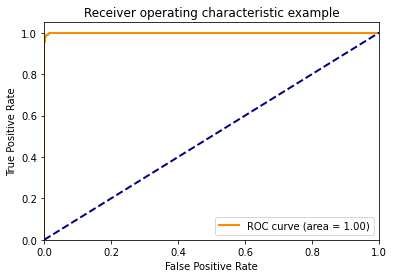

In [58]:
import matplotlib.pyplot as plt
plt.figure()
lw = 2
plt.plot(
    fpr[2],
    tpr[2],
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc[2],
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()

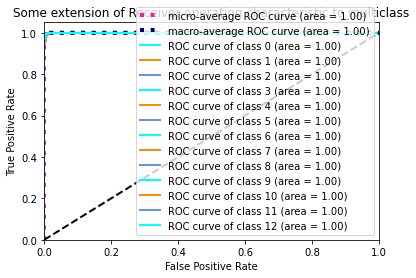

In [60]:
from itertools import cycle

n_classes = len(classes)
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(
    fpr["micro"],
    tpr["micro"],
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]),
    color="deeppink",
    linestyle=":",
    linewidth=4,
)

plt.plot(
    fpr["macro"],
    tpr["macro"],
    label="macro-average ROC curve (area = {0:0.2f})".format(roc_auc["macro"]),
    color="navy",
    linestyle=":",
    linewidth=4,
)

colors = cycle(["aqua", "darkorange", "cornflowerblue"])
for i, color in zip(range(n_classes), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        lw=lw,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Some extension of Receiver operating characteristic to multiclass")
plt.legend(loc="lower right")
plt.show()

In [64]:
macro_roc_auc_ovo = roc_auc_score(y_true, y_score, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_true, y_score, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_true, y_score, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

One-vs-One ROC AUC scores:
0.999913 (macro),
0.999904 (weighted by prevalence)
One-vs-Rest ROC AUC scores:
0.992141 (macro),
0.999904 (weighted by prevalence)


In [69]:
a = sc.read_h5ad('/data/pollock/benchmarking/results/svm_linear/scRNAseq_brca.h5ad')
a.obs

,cell_type,barcode,sample,n_counts,size_factors,predicted_cell_type,probability B cell,probability CD4 T cell,probability CD8 T cell,probability Dendritic,probability Endothelial,probability Erythrocyte,probability Fibroblast,probability Malignant,probability Mast,probability Monocyte,probability NK,probability Plasma,probability Treg
0_AACCAACTCCACTAGA-1,Endothelial,AACCAACTCCACTAGA-1,0,4712.0,1.213182,Endothelial,-1.645374,-0.798354,-1.320047,-0.613273,9.651504,0.046297,-3.343092,-0.727528,-1.168746,-0.569176,-1.320954,-0.929309,-1.167010
0_AACCCAAAGACGAGCT-1,NK,AACCCAAAGACGAGCT-1,0,4732.0,1.218332,NK,-0.844792,-1.667611,-1.252446,-0.681986,-0.991126,-1.047975,-1.393238,0.279072,-0.840426,-0.061285,10.557428,-1.192751,-1.279777
0_AACGTCAGTTTACACG-1,Endothelial,AACGTCAGTTTACACG-1,0,3296.0,0.848610,Endothelial,-0.874611,-1.563723,-0.647155,-1.483668,7.808266,-0.778172,-0.275812,-0.957157,-0.471111,-0.729114,-1.426803,-0.044268,-0.892382
0_AACTTCTGTCCAGAAG-1,CD8 T cell,AACTTCTGTCCAGAAG-1,0,3202.0,0.824408,CD8 T cell,-1.695771,-0.758672,1.230153,-1.391558,-1.419928,-0.788930,-0.927254,-0.453907,-0.026667,-0.981914,-0.534299,-1.087195,-2.054266
0_AAGCCATAGTGATTCC-1,Endothelial,AAGCCATAGTGATTCC-1,0,4088.0,1.052523,Endothelial,-0.334221,-1.272656,-0.656085,-1.552842,14.972706,-0.857209,-1.206331,-0.683234,-0.559324,-1.068178,-0.820980,-1.125220,-1.229909
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29_TTTATGCCAGCCCAGT-1,Fibroblast,TTTATGCCAGCCCAGT-1,29,4480.0,1.153450,Fibroblast,-1.617480,-0.865152,-1.466225,-0.761909,-1.233621,-0.567406,4.051761,0.728402,-0.353512,-1.202108,-0.631813,-1.264545,-0.332282
29_TTTCATGGTCGACTTA-1,Treg,TTTCATGGTCGACTTA-1,29,4580.0,1.179197,Treg,-1.489965,-0.297774,-0.895083,-1.135407,-0.943314,-0.690525,-1.695587,-2.054170,-1.055325,-0.272783,-1.668621,-0.500289,6.091204
29_TTTCCTCGTTAGCGGA-1,Treg,TTTCCTCGTTAGCGGA-1,29,4526.0,1.165293,Treg,-1.554138,-1.126189,0.067056,-1.275277,-1.274302,-1.661355,-1.579366,-0.442887,0.256902,-0.620646,-1.139950,-1.634987,5.346128
29_TTTGACTCATGGGATG-1,Plasma,TTTGACTCATGGGATG-1,29,4452.0,1.146241,Plasma,-1.184166,-1.148166,-1.161676,-0.978821,-1.056848,-1.118930,-0.771188,-0.980366,-0.481189,-1.247963,-0.962314,9.834721,-1.319493


In [70]:
classes = sorted(set(a.obs['cell_type']))
y_pred = [classes.index(l) for l in a.obs['predicted_cell_type']]
y_score = a.obs[[c for c in a.obs.columns if 'probability ' in c]].values
y_true = [classes.index(l) for l in a.obs['cell_type']]

y_pred = label_binarize(y_pred, classes=np.arange(len(classes)))
y_true = label_binarize(y_pred, classes=np.arange(len(classes)))

In [71]:
macro_roc_auc_ovo = roc_auc_score(y_true, y_score, multi_class="ovo", average="macro")
weighted_roc_auc_ovo = roc_auc_score(
    y_true, y_score, multi_class="ovo", average="weighted"
)
macro_roc_auc_ovr = roc_auc_score(y_test, y_score, multi_class="ovr", average="macro")
weighted_roc_auc_ovr = roc_auc_score(
    y_true, y_score, multi_class="ovr", average="weighted"
)
print(
    "One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovo, weighted_roc_auc_ovo)
)
print(
    "One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
    "(weighted by prevalence)".format(macro_roc_auc_ovr, weighted_roc_auc_ovr)
)

ValueError: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes